In [1]:
%pip install pykrige

  Using cached PyKrige-1.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached PyKrige-1.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (979 kB)
Note: you may need to restart the kernel to use updated packages.


In [24]:
%matplotlib widget

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure
from skimage.io import imsave, imread
from osgeo import ogr
import pystac_client
from pyproj import Transformer
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import geopandas as gpd
import pandas as pd
import geoviews as gv
import hvplot.pandas
import intake
import xarray as xr
import numpy as np
from numpy.random import default_rng
import intake
from pyproj import Proj, transform
from osgeo import gdal
from sklearn.neighbors import BallTree
import earthaccess
import gzip

# for progress bar
from ipywidgets import IntProgress
from IPython.display import display
from ipywidgets import interact, Dropdown
import time
from tqdm.notebook import trange, tqdm

import boto3
import rasterio as rio
from rasterio.features import rasterize
from rasterio.session import AWSSession
import dask
import os
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.warp import Resampling as resample
import cartopy.crs as ccrs
import cartopy
# from scipy.interpolate import BivariateSpline, UnivariateSpline
from pykrige.ok import OrdinaryKriging
from sklearn.linear_model import LinearRegression, RANSACRegressor
from scipy.odr import Model, RealData, ODR
import scipy.odr as odr
import scipy
import statsmodels.formula.api as smf
from shapely.geometry.polygon import Polygon, Point
import pygmt
import gc
import pytz
import pyproj
import math
from pathlib import Path
from matplotlib.patches import Polygon as Pgon
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Coefficients for calibration
calib_m = 0.76 
calib_b = 0.55

# Functions

In [26]:
# Functions to search and open Lansat scenes
'''
Functions to search, open, and analyze Landsat scenes.
Search_stac finds the Landsat scene based on user parameters, 
plot_search plots the locations of the landsat scenes from the search,
landsat_to_xarray takes one of those scenes and puts all bands into an xarray,
and create_masks produces cloud/ice/water masks for the scene. Subset_img 
subsets a landsat scene with coordinates that have been reprojected from lat/lon
and may be flipped in which is larger in the pair. Lsat_reproj can be used to reproject
while ensuring x and y pairs don't get flipped (common converting between espg 3031 and wgs84.
'''

def landsat_to_xarray(sceneid, catalog, bandNames=None):
    """
    Loads selected Landsat bands (and QA layers for later cloud masking) from an 
    AWS S3 bucket (via the STAC item's alternate href) into an xarray Dataset.

    Parameters
    ----------
    sceneid : intake.STAC item
        A single STAC item pointing to Landsat assets.
    catalog : ?????
    bandNames : list of str, optional
        Names of bands to load (e.g., ['red', 'swir16']). If None, all non-thermal
        bands are included by default.

    Returns
    -------
    xr.DataArray
        A 3D xarray DataArray (dimensions: band, y, x) with a scalar coordinate
        for the observation time. The bands will include 'qa_pixel', 'qa_radsat',
        and 'VZA' in addition to any requested reflectance/thermal bands.
    
    Notes
    -------
    If multiple scenes are merged later on, xarray will fill non-overlapping areas with NaNs.
    
    """

    # Retrieve the STAC item from the catalog by its ID
    item = catalog[sceneid.id]

    bands = []
    band_names = []

    if bandNames is None:
        # Get band names
        for k in item.keys():
            M = getattr(item, k).metadata
            if 'eo:bands' in M:
                resol = M['eo:bands'][0]['gsd']
                if resol >= 30: # thermal bands are up sampled from 100 to 30
                    band_names.append(k)
    else:
        band_names = bandNames

    # Add QA bands for creating cloud mask later
    if 'qa_pixel' not in band_names:
        band_names.append('qa_pixel')
    
    band_names.append('VZA')
    band_names.append('qa_radsat')

    # Construct xarray for scene by concatenating all desired bands (including QA)
    for band_name in band_names:
        asset = sceneid.assets[band_name]
        href = asset.extra_fields['alternate']['s3']['href']
        band = xr.open_dataset(href, engine='rasterio', chunks=dict(band=1, x=512, y=512))
        band['band'] = [band_name]
        bands.append(band)
    ls_scene = xr.concat(bands, dim='band')
    ls_scene.coords['id'] = sceneid.id
    ls_scene.coords['time'] = item.metadata['datetime'].strftime('%Y-%m-%dT%H:%M:%S')
    ls_scene = ls_scene['band_data']

    return ls_scene

##########################

def create_masks(ls_scene, cloud_mask=True, ice_mask=False, ocean_mask=False):
    """
    Creates cloud, ice, and ocean masks from a Landsat scene QA band. By default, 
    clouds are labeled as 1, ice as 2, ocean as 3, and all other pixels are NaN.

    Parameters
    ----------
    ls_scene : xarray.DataArray
        A Landsat scene loaded with a 'qa_pixel' band (as created by `landsat_to_xarray`).
    cloud_mask : bool, optional
        Whether to generate the cloud mask. Default is True.
    ice_mask : bool, optional
        Whether to generate the ice mask. Default is False.
    ocean_mask : bool, optional
        Whether to generate the ocean mask. Default is False.

    Returns
    -------
    xarray.DataArray
        The same input xarray object, but with an added `"mask"` coordinate. 
        In that mask, cloud pixels are assigned 1, ice pixels 2, ocean pixels 3, 
        and everything else is set to NaN.
    """
    
    cloud = []
    ocean = []
    ice = []

    qa = ls_scene.sel(band='qa_pixel').astype('uint16')

    n,c = np.unique(qa, return_counts=True)

    for j in range(len(n)):
        longform = f'{n[j]:016b}'
        if (longform[-7]=='0')|(longform[-3]=='1'): #bit 2 and 6 are for cirrus and clear sky
            cloud.append(n[j])
        if longform[-8:]=='11000000': #bit 6 and 7 give clear sky and water, lower bits need to be 0 
            ocean.append(n[j])
        if longform[-7:]=='1100000': #bit 5 and 6 give ice and clear sky 
            ice.append(n[j])

    if 0 in cloud:
        cloud.remove(0)
    if 1 in cloud:
        cloud.remove(1)

    # mask cloud, ice, and ocean
    if cloud_mask==True:
        # cloud is 2
        mask_c = xr.where(qa.isin(cloud), 1, np.nan)

    if ice_mask==True:
        mask_c = xr.where(qa.isin(ice), 2, mask_c)

    if ocean_mask==True:
        mask_c = xr.where(qa.isin(ocean), 3, mask_c)

    ls_scene.coords['mask'] = (('y', 'x'), mask_c.data)
        
    return ls_scene

##########################

def normalize(array):
    '''
    normalize a dask array so all value are between 0 and 1
    '''
    array_min = array.min(skipna=True)
    array_max = array.max(skipna=True)
    return (array - array_min) / (array_max - array_min)

##########################

def search_stac(url, collection, gjson_outfile=None, bbox=None, timeRange=None, filename=None):
    """
    Search a STAC API for Landsat images based on either:
    - Bounding box and time range, or
    - Specific filename (STAC 'id').

    Parameters:
    -----------
    url : str
        URL to the STAC API.
    collection : str
        Collection name (e.g., "landsat-c2-l2").
    gjson_outfile : str or None
        Output file to save the search result as GeoJSON (optional).
    bbox : list or None
        Bounding box [west, south, east, north] (optional).
    timeRange : str or None
        Time range in ISO format, e.g., '2021-09-01/2023-03-31' (optional).
    filename : str or None
        Exact filename (product ID) to search for (optional).

    Returns:
    --------
    item_collection : pystac.ItemCollection
        Collection of matching STAC items.
    """
    
    api = pystac_client.Client.open(url)

    if filename:
        # Search by filename (ID)
        search = api.search(
            collections=[collection],
            ids=[filename],
        )
        print(f"Searching for filename: {filename}")
    
    elif bbox and timeRange:
        # Search by bbox and timeRange
        search = api.search(
            bbox=bbox,
            datetime=timeRange,
            collections=[collection],
        )
        print(f"Searching for items in bbox {bbox} and timeRange {timeRange}")
    
    else:
        raise ValueError("Must provide either a filename, or both bbox and timeRange.")

    items = search.item_collection()

    print(f"Found {len(items)} item(s)")

    if gjson_outfile and len(items) > 0:
        items.save_object(gjson_outfile)
    
    return items

##########################

def plot_search(gf,satellite,colnm):
    # Plot search AOI and frames on a map using Holoviz Libraries (more on these later)
    cols = gf.loc[:,('id',colnm[0],colnm[1],'geometry')]
    alpha = 1/gf.shape[0]**0.5 # transparency scales w number of images

    footprints = cols.hvplot(geo=True, line_color='k', hover_cols=[colnm[0],colnm[1]], alpha=alpha, title=satellite,tiles='ESRI')
    tiles = gv.tile_sources.CartoEco.options(width=700, height=500) 
    labels = gv.tile_sources.StamenLabels.options(level='annotation')
    tiles * footprints * labels
    
    return footprints

##########################

def subset_img(da,polarx,polary):
    '''
    ***Only works for square grid cropping along the orientation of the grid (not when cropping along lat/lon in a 3031 grid
    
    Subset image in xarray to desired coordinates. Because Landsat polar stereo projection can be oriented
    in many different directions, when coordinates to subset an image are reprojected from lat/lon they may get 
    flipped for which is larger in the pair. This function checks to make sure we are getting a proper subset and 
    avoids 0 pixels on the x or y axis. 
    
    Note: Input shape dimensions and dataarray v. dataset changes things so input needs to be a dataarray w 
          2 dimensions (x,y)
    
    Input:
    da = xarray DataArray to be subset
    polarx = x coordinates to subset by in polar stereographic projection
    polary = y coordinates to subset by in polar stereographic projection
    
    Output:
    ls_sub = subset xarray DataArray
    
    '''
    # ***Landsat shape dimensions are one fewer than they are for LandsatCalibration [0,1] not [1,2], no .to_array() or Band
    ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))

    # Check for right dimensions because y order changes sometimes
    if (ls_sub.x.shape[0]==0) & (ls_sub.y.shape[0]==0):
        print ('L8 x and y shapes are 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
    elif ls_sub.y.shape[0]==0:
        print ('L8 y shape is 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1]))
    elif ls_sub.x.shape[0]==0:
        print ('L8 x shape is 0')
        ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[1],polarx[0]))
    print(ls_sub.shape)
    
    return ls_sub

##########################

def lsat_reproj(old_cs,new_cs,lbox):
    '''
    Reprojects a bounding box from an old coordinate system to a new one, and checks
    for round-trip transformation errors. The resulting bounding box coordinate order
    may be flipped if the input coordinates indicate an inverted orientation. 
    Diagnostic information is printed, and the transformed bounding box is returned.

    Parameters
    ----------
    old_cs : str
        The Proj4 or EPSG string for the original (source) coordinate system.
        For example: 'epsg:4326' or '+proj=longlat +datum=WGS84 +no_defs'.
    new_cs : str
        The Proj4 or EPSG string for the target coordinate system.
    lbox : list or tuple of float
        A bounding box specified as [ULX, LRY, LRX, ULY] in the old coordinate system.
        - ULX: Upper Left X
        - LRY: Lower Right Y
        - LRX: Lower Right X
        - ULY: Upper Left Y

    Returns
    -------
    bbox : list of tuples
        The transformed bounding box in the new coordinate system. The point order
        depends on whether the original bounding box was flipped or not:
        - Flipped orientation: [(lULX, lLLY), (lLLX, lULY), (lLRX, lURY), (lURX, lLRY)]
        - Normal orientation:  [(lULX, lULY), (lLLX, lLLY), (lLRX, lLRY), (lURX, lURY)]
    checkbox : numpy.ndarray
        An array of the round-trip check coordinates in the old coordinate system
        after transforming back from the new coordinate system. Used to verify
        the accuracy of the transformation.

    Notes
    -----
    - A threshold of 0.5 (`test_threshold`) is used to check whether the
      round-trip transformation error is too high. If the Euclidean distance
      between the original coordinates and the transformed-back coordinates
      exceeds this threshold, a warning is printed.
    - The function prints diagnostic messages, including orientation checks
      and the final bounding box. If the original bounding box was inverted
      (LRY > ULY), a 'flipped orientation' message is displayed, and the points
      are reordered accordingly.
    - The function has not been extensively tested with grids that are rotated
      or otherwise do not follow the normal bounding-box assumptions.

    Examples
    --------
    >>> old_cs = 'epsg:4326'
    >>> new_cs = 'epsg:3031'
    >>> lbox = [-60, -85, 30, -70]  # [ULX, LRY, LRX, ULY]
    >>> bbox, checkbox = lsat_reproj(old_cs, new_cs, lbox)
    >>> bbox
    [(-6671686.551, 241102.289), ... ]  # Example coordinates
    >>> checkbox
    array([-60.3, -70.1,  30.2, -84.9]) # Round-trip result

    bbox comes out with the points out of order for making a polygon though pairs are correct. Order is 0,3,1,2 when done in normal projection. 
    Haven't tested for flipped grid.
    '''
    
    test_threshold = 0.5
    
    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)
    
    ULX,LRY,LRX,ULY = lbox

    [lULX,lLRX], [lULY,lLRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
    [cULX,cLRX], [cULY,cLRY] =  transform(outProj,inProj,[lULX,lLRX], [lULY,lLRY], always_xy=True)
    [lLLX,lURX], [lLLY,lURY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)
    [cLLX,cURX], [cLLY,cURY] =  transform(outProj,inProj,[lLLX,lURX], [lLLY,lURY], always_xy=True)

    if LRY>ULY:
        bbox = [(lULX,lLLY),(lLLX,lULY),(lLRX,lURY),(lURX,lLRY)]
        print('lsat_reproj flipped orientation')
    else:
        bbox = [(lULX,lULY),(lLLX,lLLY),(lLRX,lLRY),(lURX,lURY)]
        print('lsat_reproj normal orientation')

    checkbox = np.array([cULX,cULY,cLRX,cLRY])
    if np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY])) > test_threshold:
        print(f"Round-trip transformation error 1 of {np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY]))}")
    checkbox = np.array([cLLX,cLLY,cURX,cURY])
    if np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY])) > test_threshold:
        print(f"Round-trip transformation error 2 of {np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY]))}")
    print (f'bbox={bbox}')
    print (f'lbox={lbox}')
    print (f'checkbox={checkbox}')
    
    return bbox,checkbox

##########################

def crop_xarray_dataarray_with_polygon(dataarray, polygon):
    """
    Crop an xarray.DataArray using a polygon.
    
    Parameters:
    - dataarray: xarray.DataArray with x and y coordinates.
    - polygon: Shapely Polygon object defining the crop area.
    
    Returns:
    - Cropped xarray.DataArray.
    """
    # Generate a 2D array of shapely Point objects for each grid point
    lon, lat = np.meshgrid(dataarray.x.values, dataarray.y.values)
    points = np.vectorize(Point)(lon, lat)
    
    # Create a mask where points within the polygon are True
    mask_func = np.vectorize(polygon.contains)
    mask = mask_func(points)
    
    # Convert the mask to an xarray.DataArray
    mask_da = xr.DataArray(mask, dims=["y", "x"], coords={"y": dataarray.y, "x": dataarray.x})
    
    # Apply the mask to the dataarray, cropping to the polygon
    # Use where method with drop=True to drop values outside the polygon
    cropped_dataarray = dataarray.where(mask_da, drop=True)
    
    return cropped_dataarray

##########################

def km_to_decimal_degrees(km, latitude, direction='latitude'):
    """
    Convert a distance in kilometers to decimal degrees of latitude or longitude,
    given a specific latitude.

    Parameters
    ----------
    km : float
        The distance in kilometers to be converted.
    latitude : float
        The latitude (in decimal degrees, from -90 to +90) where the conversion
        is being applied. Used only if direction='longitude'.
    direction : str, optional
        Either 'latitude' or 'longitude'. Determines whether to convert
        km to decimal degrees of latitude or longitude. Default is 'latitude'.

    Returns
    -------
    float
        The approximate decimal degrees that correspond to the given distance in km
        at the specified latitude (for longitude) or globally (for latitude).

    Notes
    -----
    1° latitude ~ 111.32 km everywhere on Earth.
    1° longitude ~ 111.32 km * cos(latitude), which is why the
        conversion depends on the specified latitude for 'longitude'.
    This function uses a spherical Earth approximation and is not exact
    at very high latitudes or for large distances.

    Examples
    --------
    >>> # Convert 10 km to decimal degrees of latitude (anywhere)
    >>> km_to_decimal_degrees(10, latitude=0, direction='latitude')
    0.0898...

    >>> # Convert 10 km to decimal degrees of longitude at latitude 69°S
    >>> km_to_decimal_degrees(10, latitude=-69, direction='longitude')
    0.2515...
    """
    if direction.lower() == 'latitude':
        # 1 degree of latitude ≈ 111.32 km (on average)
        deg = km / 111.32
    elif direction.lower() == 'longitude':
        # 1 degree of longitude ≈ 111.32 km * cos(lat)
        deg = km / (111.32 * math.cos(math.radians(latitude)))
    else:
        raise ValueError("direction must be 'latitude' or 'longitude'")
    return deg

##########################

def crosses_idl(coords):
    '''
    Determine if the set of coordinates crosses the International Dateline in a way that will mess up the creation of a polygon
    
    Variables:
    coords = list of lon, lat tuples
    
    Output:
    True or False
    '''
    
    for (lon1, lat1), (lon2, lat2) in zip(coords, coords[1:]):
        if abs(lon1 - lon2) >= 180:
            return True
    return False

In [39]:
# Atmospheric correction and production of SST
'''
Functions to find the matching MODIS water vapor image for atmospheric correction and production of SST.
Open_MODIS finds and downloads the closest MODIS water vapor image to a specific landsat image. Get_wv
aligns and subsets the modis image grid to landsat using MODISlookup and subsamples and extracts the data 
onto the Landsat grid using uniqueMODIS
'''

# def open_MODIS(ls_scene,scene,modout_path):
#     '''
#     Search MOD/MDY07 atmospheric data and open water vapor for data collected closest in time to 
#     Landsat scene.
    
#     Input:
#     ls_scene = xarray dataset with Landsat scene
#     modout_path = directory path for MODIS data
#     scene = STAC catalog item
    
#     Output:
#     mod07 = xarray dataset with MODIS (MOD/MDY07) water vapor 
#     modfilenm = MODIS filename for image used in atm correction
#     '''

#     # Get spatial extent of Landsat scene in lat/lon
#     mbbox = (scene.metadata['bbox'][0], scene.metadata['bbox'][1], scene.metadata['bbox'][2], scene.metadata['bbox'][3]) #(west, south, east, north) 
#     lsatpoly = Polygon([(mbbox[0],mbbox[1]),(mbbox[0],mbbox[3]),(mbbox[2],mbbox[3]),(mbbox[2],mbbox[1]),(mbbox[0],mbbox[1])]) # ensure full lineup between landsat and modis

#     ls_time = pd.to_datetime(ls_scene.time.values)
#     calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
#     start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
#     end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')

#     # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
#     results = earthaccess.search_data(
#         short_name='MOD07_L2',
#         bounding_box=mbbox,
#         # Day of a landsat scene to day after - searches day of only
#         temporal=(start_dt,end_dt)
#     )
#     results2 = earthaccess.search_data(
#         short_name='MYD07_L2',
#         bounding_box=mbbox,
#         # Day of a landsat scene to day after - searches day of only
#         temporal=(start_dt,end_dt)
#     )
#     results = results + results2
#     print (f'{len(results)} TOTAL granules')

#     # Accept only granules that overlap at least 100% with Landsat (percent_dif<0.1 is the other option)
#     best_grans = []
#     for granule in results:
#         try:
#             granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
#         except Exception as error:
#             print(error)
#             continue
#         for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
#             try:
#                 map_points = [(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']]
#                 pgon = Polygon(map_points)
#                 percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
#                 if percent_dif < 0.1:
#                     if crosses_idl(map_points):
#                         print (f'A granule has messed up polygon that likely crosses the International DateLine')
#                     else:
#                         best_grans.append(granule)
#                         continue
#             except Exception as error:
#                 print(error)
#                 # Would love to raise an exception for a valueerror except for GEOSError but not sure how 
#     print(f'{len(best_grans)} TOTAL granules w overlap')

#     # Find MODIS image closest in time to the Landsat image
#     Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
#     ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(pd.to_datetime(ls_time)))))
#     print(f'Time difference between MODIS and Landsat: {abs(Mdates[ind] - pytz.utc.localize(pd.to_datetime(ls_time)))}')

#     # Download MODIS data if needed

#     # # This doesn't work because xarray can't open legacy HDF EOS data formats
#     # mod07 = xr.open_mfdataset(earthaccess.open(results))

#     # Use these access pathways while S3 streaming is not working
#     data_links = [granule.data_links(access="external") for granule in best_grans[ind:ind+1]]
#     netcdf_list = [g._filter_related_links("USE SERVICE API")[0].replace(".html", ".nc4") for g in best_grans[ind:ind+1]]
#     # This is going to be slow as we are asking Opendap to format HDF into NetCDF4 so we only processing 3 granules
#     # and Opendap is very prone to failures due concurrent connections, not ideal.
#     file_handlers = earthaccess.download(netcdf_list,modout_path,provider='NSIDC')

#     # Open MODIS data
#     mod_list = os.listdir(modout_path)
#     mod_list = [file for file in mod_list if file[-3:]=='nc4']
#     print(mod_list)
#     modfilenm = mod_list[0]
    
#     os.rename(f'{modout_path}/{modfilenm}', f'{modout_path}/{modfilenm}.gz')
#     with gzip.open(f'{modout_path}/{modfilenm}.gz', 'rb') as f_in:
#         with open(f'{modout_path}/{modfilenm}', 'wb') as f_out:
#             f_out.write(f_in.read())

#     mod07 = xr.open_dataset(f'{modout_path}/{modfilenm}')
#     mod07 = mod07.rio.write_crs('epsg:4326')

#     # Delete MODIS file
#     os.remove(f'{modout_path}/{modfilenm}')
#     os.remove(f'{modout_path}/{modfilenm}.gz')
    
#     return mod07,modfilenm

# ##########################

# # Notes for changes - MODISlookup2 doesn't need to output lat/lon, but if want to do the check, 
# # can take the lat/lon check out of aligne and do it in 
# def get_wv(ls_scene,mod07,spacing,param,scene,interp=0):
#     '''
#     Aligns and resamples MODIS water vapor data to match the spatial resolution and 
#     alignment of a given Landsat scene. The function optionally applies interpolation 
#     to improve the data quality.

#     Parameters:
#     ls_scene (xarray.Dataset): The Landsat scene dataset containing spatial coordinates.
#     mod07 (xarray.Dataset): The MODIS dataset containing water vapor data and coordinates (MOD/MDY07).
#     spacing (list): Desired spatial resolution (y, x) for alignment with MODIS data in meters.
#     param (str): Parameter name for the desired dataset within the MODIS file.
#     scene: 
#     interp (int): Controls interpolation mode - 0 for none, 1 for bicubic kriging interpolation.

#     Returns:
#     WV_xr (xarray.DataArray): The processed xarray data array containing the Landsat-aligned 
#                               and resampled water vapor data from MODIS.

#     Note:
#     This function is also used in LandsatCalibration; any changes here should consider potential impacts there 
#     - may need to be copied/generalized.

#     The function performs several key operations:
#     1. Defines the bounding box for the Landsat scene based on its spatial coordinates.
#     2. Extracts the relevant water vapor data from the MODIS dataset using the specified parameter key.
#     3. Validates the geographic coordinate ranges (latitude and longitude) of the MODIS data.
#     4. Applies PyGMT interpolation if requested to generate a smoother water vapor data surface.
#     5. Utilizes a lookup function to align MODIS data indices with the Landsat grid based on the specified spatial resolution.
#     6. Aligns and resamples the MODIS data to match the Landsat scene's grid and spatial resolution.
#     7. Adjusts the coordinate system of the output to ensure compatibility with further processing or analysis.

#     Difference: no bicubic spline interpolation in LsatCalib during the upsampling, don't set new indexes at the end
#     '''
#     # Read in desired variables
#     ULX = ls_scene.x[0] 
#     ULY = ls_scene.y[0]  
#     LRX = ls_scene.x[-1] 
#     LRY = ls_scene.y[-1] 
#     box = [ULX,LRX,ULY,LRY]
    
#     #Extract desired datasets from MODIS file from lookup key
#     data = mod07[param].values
#     lat, lon = mod07.Latitude, mod07.Longitude
#     #data.attributes()

#     # Test lat is in correct range
#     if ~((lat <= 90) & (lat >= -90)).all():
#         print('MODIS latitude not between -90 and 90')
#     # Test lon is in correct range
#     if ~((lon <= 180) & (lon >= -180)).all():
#         print('MODIS longitude not between -180 and 180')

#     # ***Need to use climatology to retrieve quantile data from this area
    
#     # # Get rid of low outliers from over ice, cutoff for 98.5%
#     # outlier = np.quantile(data[np.isfinite(data)],0.015) #0.015
#     # mask2 = np.ones(data.shape)
#     # mask2[data<outlier] = np.nan
#     # data = np.around(mask2*data,decimals=5)

#     # Interpolate using PyGMT
#     if interp==1:  
#         grid = interpMOD(data,lat,lon)
        
#         # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
#         indiciesMOD,lines,samples,lat,lon = MODISlookup(mod07,ls_scene,box,spacing,scene,interpgrid=grid)
#         data = grid.values
        
#     else:
#         # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
#         indiciesMOD,lines,samples,lat,lon = MODISlookup(mod07,ls_scene,box,spacing,scene)

#     # Align and resample MODIS WV to Landsat at indicated spacing with correct axes
#     dataOutWV_xr = alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing)
    
#     # # Resample WV to Landsat resolution and interpolate with B-spline
#     # # Need to use 0.1k (this samples at .1 of the grid)
#     # # Output of shape fits and need to adjust x and y coords cuz are wrong
#     ups_factor = 30/spacing[0]
#     WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k', interpolation='c')
#     # WV_upsample = xr.open_dataarray(lsatpath+'WV_upsample_B-spline_'+str(ls_scene.id.values))
#     # # Resample WV to Landsat resolution manual - no interpolation
#     # WV_resamp = MODresample(ls_scene,dataOutWV,y1,x1,spacing)

#     # Put into Xarray
#     # Sometimes spacing works properly with -1 and sometimes not
#     latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]-1))
#     if (WV_upsample.shape[0]!=latnew.shape[0]):
#         latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]))

#     # Put into Xarray
#     latnew = ls_scene.y[:WV_upsample.shape[0]].values
#     lonnew = ls_scene.x[:WV_upsample.shape[1]].values
#     if dataOutWV_xr.latitude[0]!=latnew[0]:
#         print('Aligned y dim needs to start with the same coordinate as ls_scene')
#     if dataOutWV_xr.longitude[0]!=lonnew[0]:
#         print('Aligned x dim needs to start with the same coordinate as ls_scene')
    
#     WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})

#     WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
#     WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})
    
#     return WV_xr

# ##########################
            
# def interpMOD(data,lat,lon):
#     """
#     Interpolate spatial water vapor data using PyGMT.

#     This function takes arrays of water vapor data along with corresponding latitude and longitude values,
#     performs interpolation to fill in gaps in the data, and produces a continuous surface representation of water vapor.

#     Args:
#         data (numpy.ndarray): 2D array of water vapor measurements.
#         lat (numpy.ndarray): 2D array of latitude values corresponding to `data`.
#         lon (numpy.ndarray): 2D array of longitude values corresponding to `data`.

#     Returns:
#         grid (xarray.DataArray): A PyGMT grid object representing the interpolated surface of water vapor data.
#     """
    
#     # Interpolate using PyGMT
#     # Extract necessary data into Pandas DataFrame (required for PyGMT)
#     df = pd.DataFrame({
#         'longitude': lon.values.flatten(), # Flatten to convert from 2D to 1D array
#         'latitude': lat.values.flatten(),
#         'water_vapor': data.flatten() # Actual data values to be interpolated
#     })

#     # Remove missing or NaN values from DataFrame, as `surface` cannot handle them
#     df = df.dropna(subset=['water_vapor'])

#     # Determine the geographical extent for the interpolation based on the provided data points.
#     # This is necessary to define the spatial domain over which PyGMT will perform interpolation.
#     # [xmin, xmax, ymin, ymax] - made this the full image
#     region = [df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max()]
#     # Alternatively, if the region is predefined (e.g., from metadata), it can be set directly.

#     # Use PyGMT to interpolate the data. PyGMT requires a session context to manage memory and configuration
#     # settings efficiently during its operations.
#     with pygmt.clib.Session() as session:
#         # Perform grid-based surface interpolation.
#         # The `data` parameter takes longitude, latitude, and water vapor as a NumPy array.
#         # `region` specifies the geographical extent.
#         # `spacing` sets the resolution of the output grid, here 0.3 km for high resolution.
#         # `tension` controls the stiffness of the interpolating surface. A value of 0.25 gives a balance between
#         # fitting the data closely and producing a smooth surface.
#         grid = pygmt.surface(
#             data=df[['longitude', 'latitude', 'water_vapor']].to_numpy(),  # Input data as NumPy array
#             region=region,  
#             spacing=['0.15k','0.05k'],  # f'0.3k'
#             tension=0.95,  
#         )   
    
#     return grid

# ##########################

# def MODISlookup(mod07,lsat_filt_msk,box,spacing,scene,interpgrid=None):
#     '''
#     Look up indices for aligning MODIS product to the Landsat grid
#     # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
#     # and Shane Grigsby

#     Variables:    
#     mod07 = xarray with MODIS data with crs 4326 assigned
#     lsat_filt_msk =  Landsat xarray DataArray
#     box = list with [left easting,right easting,top northing,bottom northing]
#     spacing = desired pixel size for extraction, list of [east/west, north/south] 
#           (recommend choosing a number that allows for fast calculations and even division by 30)
#     scene = 
#     interpgrid = xarray of mod07 data that has been through interpolation in PyGMT (optional)

#     Output:
#     indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
#     lines = number of lines in Landsat file/MODIS output shape
#     samples = number of samples in Landsat file/MODIS output shape
#     lon,lat = 2D lon and lat coordinates for grid
#     '''
#     test_threshold = 5
    
#     if interpgrid is None:
#         lat, lon = mod07.Latitude.values, mod07.Longitude.values
#     else:
#         lat, lon = interpgrid.lat, interpgrid.lon
#         lon, lat = np.meshgrid(lon,lat)

#     # Test lat is in correct range
#     if ~((lat <= 90) & (lat >= -90)).all():
#         print('MODIS latitude not between -90 and 90')
#     # Test lon is in correct range
#     if ~((lon <= 180) & (lon >= -180)).all():
#         print('MODIS longitude not between -180 and 180')

#     # Get the existing coordinate system
#     old_cs = ls_scene.rio.crs # 'epsg:3031'
#     new_cs = mod07.rio.crs # 'epsg:4326'

#     # Create a transform object to convert between coordinate systems
#     inProj = Proj(init=old_cs)
#     outProj = Proj(init=new_cs)

#     # Parse coordinates and spacing to different variables
#     west,east,north,south = box
#     ewspace,nsspace = spacing

#     # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
#     samples = len(np.r_[west:east+1:ewspace])
#     lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
#     if lines==0:
#         lines = len(np.r_[south:north-1:nsspace])

#     # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
#     ewdnsamp = int(spacing[0]/30)
#     nsdnsamp = int(spacing[1]/30)
    
#     # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
#     xresamp = ls_scene.x.isel(x=slice(None, None, ewdnsamp)).values
#     if xresamp[0]!=ls_scene.x.values[0]:
#         xresamp = ls_scene.x.isel(x=slice(None, None, -ewdnsamp)).values
#         print('x resample reversed')
#     yresamp = ls_scene.y.isel(y=slice(None, None, nsdnsamp)).values
#     if yresamp[0]!=ls_scene.y.values[0]:
#         yresamp = ls_scene.y.isel(y=slice(None, None, -nsdnsamp)).values
#         print('y resample reversed')
#     x1, y1 = np.meshgrid(xresamp,yresamp)
#     LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
#     if (LScoords[0,0]!=ls_scene.x.values[0]) |  (LScoords[0,1]!=ls_scene.y.values[0]):
#         raise Exception('Landsat coordinates do not match expected during MODIS lookup')

#     # Ravel so ND can lookup easily
#     # Convert from LS map coords to lat lon --> x = lon, y = lat (usually?)

#     ###Make into test
#     # Test that reprojection is working correctly on first and last grid point using round-trip transformation
#     xs1, ys1 =  transform(inProj,outProj,LScoords[0,0], LScoords[0,1], radians=True, always_xy=True)
#     xsl1, ysl1 =  transform(outProj,inProj,xs1, ys1, radians=True, always_xy=True)
#     if np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:]) > test_threshold:
#         print(f"Round-trip transformation error for point {LScoords[0,:]}, {np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:])}")
#     else:
#         # If passes, run on entire grid
#         xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)
#     ###
    
#     # Produce landsat reprojected to lat/lon and ensure lat is in 0 column
#     # Test: landsat data is in correct orientation as long as lat is in col 0 and lon in col 1
#     grid_coords = test_gridcoords(xs,ys,scene)

#     # Test that lines and samples match grid_coords
#     if len(grid_coords) != lines*samples:
#         raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}. Check that spacing is negative for y')
#     MODIS_coords = np.vstack([lat.ravel(),lon.ravel()]).T
#     MODIS_coords *= np.pi / 180. # to radians

#     # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
#     MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
#     distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
#     return indiciesMOD,lines,samples,lat,lon

# ##########################

# def test_gridcoords(xs,ys,scene):
#     '''
#     Test to ensure grid lat and lon are not swapped during reprojection and output grid coordinates
#     that have been raveled and stacked for input into BallTree
    
#     Variables:
#     xs = 1D radians representing longitude 
#     ys = 1D radians representing latitude
#     scene = catalog item for landsat image
    
#     Output:
#     grid_coords = two columns of x/y radian pairs representing lon/lat
#     '''
    
#     # Convert radians to lat/lon
#     x_check = xs * 180. / np.pi
#     y_check = ys * 180. / np.pi
    
#     # We know lat is ys and lon is xs if this is true so goes in 0 column position to match MODIS
#     if ((-90 <= y_check) & (y_check <= -60)).all() & ~((-90 <= x_check) & (x_check <= -60)).all():
#         grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
#         print('Latitude in proper position')

#     # A small subset of data have lat and lon that falls between -60 and -90 so test if the landsat metadata confirms that
#     elif ((-90 <= y_check) & (y_check <= -60)).all():
#         llons = np.array((float(scene.metadata['bbox'][0]), float(scene.metadata['bbox'][2])))
#         # ys is latitude if true here
#         if ((-90 <= llons) & (llons <= -60)).all():
#             grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
#             print('Latitude in proper position')
#         # xs is latitude if not and goes in 0 column position
#         else:
#             grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T 
#             print('Latitude in wrong position')

#     # Otherwise xs is latitude and goes in 0 column position
#     else:
#         grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T
#         print('Latitude in wrong position')
    
#     return grid_coords

# ##########################

# def alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing):
#     test_threshold = 5
    
#     # Check to ensure lat/lon and data have compatible shapes
#     if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
#         raise Exception("Error in creating indicies, lat/lon and data shapes do not match")
        
#     # Extract MODIS data into Landsat grid and gather unique data values
#     dataOut,uniqWV = uniqueMODIS(data,param,indiciesMOD,lines,samples)
    
#     # Check grid directionality and create matching x/y for new grid
#     # Define the source and target coordinate reference systems (CRS)
#     src_crs = mod07.rio.crs #'epsg:4326'  MODIS
#     target_crs = ls_scene.rio.crs #crs[6:] # 'epsg:3031' Landsat

#     # Create a PyProj transformer
#     transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
#     transformer_test = pyproj.Transformer.from_crs(target_crs, src_crs, always_xy=True)

#     # Test that reprojection is working correctly on first and last modis grid point
#     xm1,xm2 = lon[0,0],lon[-1,-1]
#     ym1,ym2 = lat[0,0],lat[-1,-1]
#     xx,yy = [xm1,xm2], [ym1,ym2]
#     xs1, ys1 =  transformer.transform(xx,yy)
#     xsl1, ysl1 = transformer_test.transform(xs1, ys1)
#     for i,n in enumerate(xsl1):
#         if np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - [xx[i],yy[i]]) > test_threshold:
#             print(f"Round-trip transformation error for {sceneid}, {np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - xx[i],yy[i])}")
    
#     # Spacing to create x and y parameters at the correct spacing
#     redy = int(abs(spacing[0]/30))
#     redx = int(abs(spacing[1]/30))

#     # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
#     xgrid = ls_scene.x.isel(x=slice(None, None, redx)).values
#     if xgrid[0]!=ls_scene.x.values[0]:
#         xgrid = ls_scene.x.isel(x=slice(None, None, -redx)).values
#     ygrid = ls_scene.y.isel(y=slice(None, None, redy)).values
#     if ygrid[0]!=ls_scene.y.values[0]:
#         ygrid = ls_scene.y.isel(y=slice(None, None, -redy)).values
#     if (xgrid[0]!=ls_scene.x.values[0]) |  (ygrid[0]!=ls_scene.y.values[0]):
#         raise Exception('Landsat coordinates do not match expected during MODIS lookup')
    
#     # Create xarray from numpy array
#     dataOut_xr = xr.DataArray(dataOut,name='SST',dims=["y","x"], coords={"latitude": (["y"],ygrid), "longitude": (["x"],xgrid)})
    
#     return dataOut_xr

# ##########################

# def uniqueMODIS(data,param,indiciesMOD,lines,samples):
#     '''
#     Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
#     # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
#     Variables: 
#     data = array with MOD07 data in crs 4326 assigned 
#     param =  string for desired dataset from MODIS file
#     indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
#     lines = number of lines in Landsat file/MODIS output shape
#     samples = number of samples in Landsat file/MODIS output shape
    
#     Output:
#     dataOut = MODIS atm image subset and aligned to Landsat image pixels
#     uniq = uniq MODIS atm values within area of Landsat image
#     #counts = count for each unique value in subset
#     '''
#     # Convert from K to C
#     KtoC = -273.15
    
#     # Scaling coefficients for MODIS data
#     wv_scale = 0.0010000000474974513
#     ozone_scale = 0.10000000149011612

#     # Reproject data from MODIS into corresponding postions for Landsat pixels for water vapor and ozone
#     if param == 'sst':
#         dataOut = np.reshape(np.array(data.ravel())[indiciesMOD],(lines,samples))#* # to scale?
#         dataOut[dataOut < -3] = np.nan
#         MODimg = np.array(data)#* # to scale?
#         MODimg[MODimg < 0] = np.nan
#     elif param == 'Water_Vapor':
#         dataOut = np.reshape(np.array(data.ravel())[indiciesMOD] * wv_scale,(lines,samples))
#         dataOut[dataOut < 0] = np.nan
#         MODimg = np.array(data*wv_scale)
#         MODimg[MODimg < 0] = np.nan
#     elif param == 'Total_Ozone':
#         dataOut = np.reshape(np.array(data.ravel())[indiciesMOD] * ozone_scale,(lines,samples))
#         dataOut[dataOut < 225] = np.nan
#         dataOut[dataOut > 430] = np.nan
#         MODimg = np.array(data*ozone_scale)
#         MODimg[MODimg < 0] = np.nan

#     # Get unique values for datasets within Landsat extent
#     #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
#     uniq = set(dataOut[np.isfinite(dataOut)])
    
#     return dataOut,uniq # Can also output MODimg and inverse and counts if desired


# Atmospheric correction and production of SST
'''
Functions to find the matching MODIS water vapor image for atmospheric correction and production of SST.
Open_MODIS finds and downloads the closest MODIS water vapor image to a specific landsat image. Get_wv
aligns and subsets the modis image grid to landsat using MODISlookup and subsamples and extracts the data 
onto the Landsat grid using uniqueMODIS
'''

def open_MODIS(ls_scene,scene,modout_path):
    '''
    Search MOD/MDY07 atmospheric data and open water vapor for data collected closest in time to 
    Landsat scene.
    
    Input:
    ls_scene = xarray dataset with Landsat scene
    modout_path = directory path for MODIS data
    scene = STAC catalog item
    
    Output:
    mod07 = xarray dataset with MODIS (MOD/MDY07) water vapor 
    modfilenm = MODIS filename for image used in atm correction
    '''

    # Get spatial extent of Landsat scene in lat/lon
    mbbox = (scene.metadata['bbox'][0], scene.metadata['bbox'][1], scene.metadata['bbox'][2], scene.metadata['bbox'][3]) #(west, south, east, north) 
    lsatpoly = Polygon([(mbbox[0],mbbox[1]),(mbbox[0],mbbox[3]),(mbbox[2],mbbox[3]),(mbbox[2],mbbox[1]),(mbbox[0],mbbox[1])]) # ensure full lineup between landsat and modis

    ls_time = pd.to_datetime(ls_scene.time.values)
    calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
    end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')

    # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
    results = earthaccess.search_data(
        short_name='MOD07_L2',
        bounding_box=mbbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    results2 = earthaccess.search_data(
        short_name='MYD07_L2',
        bounding_box=mbbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    results = results + results2
    print (f'{len(results)} TOTAL granules')

    # Accept only granules that overlap at least 100% with Landsat (percent_dif<0.1 is the other option)
    best_grans = []
    for granule in results:
        try:
            granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
        except Exception as error:
            print(error)
            continue
        for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
            try:
                map_points = [(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']]
                pgon = Polygon(map_points)
                percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
                if percent_dif < 0.1:
                    if crosses_idl(map_points):
                        print (f'A granule has messed up polygon that likely crosses the International DateLine')
                    else:
                        best_grans.append(granule)
                        continue
            except Exception as error:
                print(error)
                # Would love to raise an exception for a valueerror except for GEOSError but not sure how 
    print(f'{len(best_grans)} TOTAL granules w overlap')

    # Find MODIS image closest in time to the Landsat image
    Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
    ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(pd.to_datetime(ls_time)))))
    print(f'Time difference between MODIS and Landsat: {abs(Mdates[ind] - pytz.utc.localize(pd.to_datetime(ls_time)))}')

    # Download MODIS data if needed

    # # This doesn't work because xarray can't open legacy HDF EOS data formats
    # mod07 = xr.open_mfdataset(earthaccess.open(results))

    # Use these access pathways while S3 streaming is not working
    data_links = [granule.data_links(access="external") for granule in best_grans[ind:ind+1]]
    netcdf_list = [g._filter_related_links("USE SERVICE API")[0].replace(".html", ".nc4") for g in best_grans[ind:ind+1]]
    # This is going to be slow as we are asking Opendap to format HDF into NetCDF4 so we only processing 3 granules
    # and Opendap is very prone to failures due concurrent connections, not ideal.
    file_handlers = earthaccess.download(netcdf_list,modout_path,provider='NSIDC')

    # Open MODIS data
    mod_list = os.listdir(modout_path)
    mod_list = [file for file in mod_list if file[-3:]=='nc4']
    print(mod_list)
    modfilenm = mod_list[0]
    
    os.rename(f'{modout_path}/{modfilenm}', f'{modout_path}/{modfilenm}.gz')
    with gzip.open(f'{modout_path}/{modfilenm}.gz', 'rb') as f_in:
        with open(f'{modout_path}/{modfilenm}', 'wb') as f_out:
            f_out.write(f_in.read())

    mod07 = xr.open_dataset(f'{modout_path}/{modfilenm}')
    mod07 = mod07.rio.write_crs('epsg:4326')

    # Delete MODIS file
    os.remove(f'{modout_path}/{modfilenm}')
    os.remove(f'{modout_path}/{modfilenm}.gz')
    
    return mod07,modfilenm

##########################

# Notes for changes - MODISlookup2 doesn't need to output lat/lon, but if want to do the check, 
# can take the lat/lon check out of aligne and do it in 
def get_wv(ls_scene,mod07,spacing,param,scene,interp=0):
    '''
    Aligns and resamples MODIS water vapor data to match the spatial resolution and 
    alignment of a given Landsat scene. The function optionally applies interpolation 
    to improve the data quality.

    Parameters:
    ls_scene (xarray.Dataset): The Landsat scene dataset containing spatial coordinates.
    mod07 (xarray.Dataset): The MODIS dataset containing water vapor data and coordinates (MOD/MDY07).
    spacing (list): Desired spatial resolution (y, x) for alignment with MODIS data in meters.
    param (str): Parameter name for the desired dataset within the MODIS file.
    scene: 
    interp (int): Controls interpolation mode - 0 for none, 1 for bicubic kriging interpolation.

    Returns:
    WV_xr (xarray.DataArray): The processed xarray data array containing the Landsat-aligned 
                              and resampled water vapor data from MODIS.

    Note:
    This function is also used in LandsatCalibration; any changes here should consider potential impacts there 
    - may need to be copied/generalized.

    The function performs several key operations:
    1. Defines the bounding box for the Landsat scene based on its spatial coordinates.
    2. Extracts the relevant water vapor data from the MODIS dataset using the specified parameter key.
    3. Validates the geographic coordinate ranges (latitude and longitude) of the MODIS data.
    4. Applies PyGMT interpolation if requested to generate a smoother water vapor data surface.
    5. Utilizes a lookup function to align MODIS data indices with the Landsat grid based on the specified spatial resolution.
    6. Aligns and resamples the MODIS data to match the Landsat scene's grid and spatial resolution.
    7. Adjusts the coordinate system of the output to ensure compatibility with further processing or analysis.

    Difference: no bicubic spline interpolation in LsatCalib during the upsampling, don't set new indexes at the end
    '''
    # Read in desired variables
    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]  
    LRX = ls_scene.x[-1] 
    LRY = ls_scene.y[-1] 
    box = [ULX,LRX,ULY,LRY]
    
    #Extract desired datasets from MODIS file from lookup key (automatically scaled by xarray so no need to do it here)
    data = mod07[param].values
    lat, lon = mod07.Latitude, mod07.Longitude
    #data.attributes()

    # Test lat is in correct range
    if ~((lat <= 90) & (lat >= -90)).all():
        print('MODIS latitude not between -90 and 90')
    # Test lon is in correct range
    if ~((lon <= 180) & (lon >= -180)).all():
        print('MODIS longitude not between -180 and 180')

    # ***Need to use climatology to retrieve quantile data from this area
    
    # # Get rid of low outliers from over ice, cutoff for 98.5%
    # outlier = np.quantile(data[np.isfinite(data)],0.015) #0.015
    # mask2 = np.ones(data.shape)
    # mask2[data<outlier] = np.nan
    # data = np.around(mask2*data,decimals=5)

    # Interpolate using PyGMT
    if interp==1:  
        grid = interpMOD(data,lat,lon)
        
        # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
        indiciesMOD,lines,samples,lat,lon = MODISlookup(mod07,ls_scene,box,spacing,scene,interpgrid=grid)
        data = grid.values
        
    else:
        # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
        indiciesMOD,lines,samples,lat,lon = MODISlookup(mod07,ls_scene,box,spacing,scene)

    # Align and resample MODIS WV to Landsat at indicated spacing with correct axes
    dataOutWV_xr = alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing)
    
    # # Resample WV to Landsat resolution and interpolate with B-spline
    # # Need to use 0.1k (this samples at .1 of the grid)
    # # Output of shape fits and need to adjust x and y coords cuz are wrong
    ups_factor = 30/spacing[0]
    WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k', interpolation='c')

    # Put into Xarray
    # Sometimes spacing works properly with -1 and sometimes not
    latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]-1))
    if (WV_upsample.shape[0]!=latnew.shape[0]):
        latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]))

    # Put into Xarray
    latnew = ls_scene.y[:WV_upsample.shape[0]].values
    lonnew = ls_scene.x[:WV_upsample.shape[1]].values
    if dataOutWV_xr.latitude[0]!=latnew[0]:
        print('Aligned y dim needs to start with the same coordinate as ls_scene')
    if dataOutWV_xr.longitude[0]!=lonnew[0]:
        print('Aligned x dim needs to start with the same coordinate as ls_scene')
    
    WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})

    WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
    WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})
    
    return WV_xr

##########################
            
def interpMOD(data,lat,lon):
    """
    Interpolate spatial water vapor data using PyGMT.

    This function takes arrays of water vapor data along with corresponding latitude and longitude values,
    performs interpolation to fill in gaps in the data, and produces a continuous surface representation of water vapor.

    Args:
        data (numpy.ndarray): 2D array of water vapor measurements.
        lat (numpy.ndarray): 2D array of latitude values corresponding to `data`.
        lon (numpy.ndarray): 2D array of longitude values corresponding to `data`.

    Returns:
        grid (xarray.DataArray): A PyGMT grid object representing the interpolated surface of water vapor data.
    """
    
    # Interpolate using PyGMT
    # Extract necessary data into Pandas DataFrame (required for PyGMT)
    df = pd.DataFrame({
        'longitude': lon.values.flatten(), # Flatten to convert from 2D to 1D array
        'latitude': lat.values.flatten(),
        'water_vapor': data.flatten() # Actual data values to be interpolated
    })

    # Remove missing or NaN values from DataFrame, as `surface` cannot handle them
    df = df.dropna(subset=['water_vapor'])

    # Determine the geographical extent for the interpolation based on the provided data points.
    # This is necessary to define the spatial domain over which PyGMT will perform interpolation.
    # [xmin, xmax, ymin, ymax] - made this the full image
    region = [df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max()]
    # Alternatively, if the region is predefined (e.g., from metadata), it can be set directly.

    # Use PyGMT to interpolate the data. PyGMT requires a session context to manage memory and configuration
    # settings efficiently during its operations.
    with pygmt.clib.Session() as session:
        # Perform grid-based surface interpolation.
        # The `data` parameter takes longitude, latitude, and water vapor as a NumPy array.
        # `region` specifies the geographical extent.
        # `spacing` sets the resolution of the output grid, here 0.3 km for high resolution.
        # `tension` controls the stiffness of the interpolating surface. A value of 0.25 gives a balance between
        # fitting the data closely and producing a smooth surface.
        grid = pygmt.surface(
            data=df[['longitude', 'latitude', 'water_vapor']].to_numpy(),  # Input data as NumPy array
            region=region,  
            spacing=['0.15k','0.05k'],  # f'0.3k'
            tension=0.95,  
        )   
    
    return grid

##########################

def MODISlookup(mod07,lsat_filt_msk,box,spacing,scene,interpgrid=None):
    '''
    Look up indices for aligning MODIS product to the Landsat grid
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
    # and Shane Grigsby

    Variables:    
    mod07 = xarray with MODIS data with crs 4326 assigned
    lsat_filt_msk =  Landsat xarray DataArray
    box = list with [left easting,right easting,top northing,bottom northing]
    spacing = desired pixel size for extraction, list of [east/west, north/south] 
          (recommend choosing a number that allows for fast calculations and even division by 30)
    scene = 
    interpgrid = xarray of mod07 data that has been through interpolation in PyGMT (optional)

    Output:
    indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    lon,lat = 2D lon and lat coordinates for grid
    '''
    test_threshold = 5
    
    if interpgrid is None:
        lat, lon = mod07.Latitude.values, mod07.Longitude.values
    else:
        lat, lon = interpgrid.lat, interpgrid.lon
        lon, lat = np.meshgrid(lon,lat)

    # Test lat is in correct range
    if ~((lat <= 90) & (lat >= -90)).all():
        print('MODIS latitude not between -90 and 90')
    # Test lon is in correct range
    if ~((lon <= 180) & (lon >= -180)).all():
        print('MODIS longitude not between -180 and 180')

    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs # 'epsg:3031'
    new_cs = mod07.rio.crs # 'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)

    # Parse coordinates and spacing to different variables
    west,east,north,south = box
    ewspace,nsspace = spacing

    # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
    samples = len(np.r_[west:east+1:ewspace])
    lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
    if lines==0:
        lines = len(np.r_[south:north-1:nsspace])

    # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
    ewdnsamp = int(spacing[0]/30)
    nsdnsamp = int(spacing[1]/30)
    
    # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
    xresamp = ls_scene.x.isel(x=slice(None, None, ewdnsamp)).values
    if xresamp[0]!=ls_scene.x.values[0]:
        xresamp = ls_scene.x.isel(x=slice(None, None, -ewdnsamp)).values
        print('x resample reversed')
    yresamp = ls_scene.y.isel(y=slice(None, None, nsdnsamp)).values
    if yresamp[0]!=ls_scene.y.values[0]:
        yresamp = ls_scene.y.isel(y=slice(None, None, -nsdnsamp)).values
        print('y resample reversed')
    x1, y1 = np.meshgrid(xresamp,yresamp)
    LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
    if (LScoords[0,0]!=ls_scene.x.values[0]) |  (LScoords[0,1]!=ls_scene.y.values[0]):
        raise Exception('Landsat coordinates do not match expected during MODIS lookup')

    # Ravel so ND can lookup easily
    # Convert from LS map coords to lat lon --> x = lon, y = lat (usually?)

    ###Make into test
    # Test that reprojection is working correctly on first and last grid point using round-trip transformation
    xs1, ys1 =  transform(inProj,outProj,LScoords[0,0], LScoords[0,1], radians=True, always_xy=True)
    xsl1, ysl1 =  transform(outProj,inProj,xs1, ys1, radians=True, always_xy=True)
    if np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:]) > test_threshold:
        print(f"Round-trip transformation error for point {LScoords[0,:]}, {np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:])}")
    else:
        # If passes, run on entire grid
        xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)
    ###
    
    # Produce landsat reprojected to lat/lon and ensure lat is in 0 column
    # Test: landsat data is in correct orientation as long as lat is in col 0 and lon in col 1
    grid_coords = test_gridcoords(xs,ys,scene)

    # Test that lines and samples match grid_coords
    if len(grid_coords) != lines*samples:
        raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}. Check that spacing is negative for y')
    MODIS_coords = np.vstack([lat.ravel(),lon.ravel()]).T
    MODIS_coords *= np.pi / 180. # to radians

    # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
    MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
    distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
    return indiciesMOD,lines,samples,lat,lon

##########################

def test_gridcoords(xs,ys,scene):
    '''
    Test to ensure grid lat and lon are not swapped during reprojection and output grid coordinates
    that have been raveled and stacked for input into BallTree
    
    Variables:
    xs = 1D radians representing longitude 
    ys = 1D radians representing latitude
    scene = catalog item for landsat image
    
    Output:
    grid_coords = two columns of x/y radian pairs representing lon/lat
    '''
    
    # Convert radians to lat/lon
    x_check = xs * 180. / np.pi
    y_check = ys * 180. / np.pi
    
    # We know lat is ys and lon is xs if this is true so goes in 0 column position to match MODIS
    if ((-90 <= y_check) & (y_check <= -60)).all() & ~((-90 <= x_check) & (x_check <= -60)).all():
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
        print('Latitude in proper position')

    # A small subset of data have lat and lon that falls between -60 and -90 so test if the landsat metadata confirms that
    elif ((-90 <= y_check) & (y_check <= -60)).all():
        llons = np.array((float(scene.metadata['bbox'][0]), float(scene.metadata['bbox'][2])))
        # ys is latitude if true here
        if ((-90 <= llons) & (llons <= -60)).all():
            grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
            print('Latitude in proper position')
        # xs is latitude if not and goes in 0 column position
        else:
            grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T 
            print('Latitude in wrong position')

    # Otherwise xs is latitude and goes in 0 column position
    else:
        grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T
        print('Latitude in wrong position')
    
    return grid_coords

##########################

def alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing):
    test_threshold = 5
    
    # Check to ensure lat/lon and data have compatible shapes
    if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
        raise Exception("Error in creating indicies, lat/lon and data shapes do not match")
        
    # Extract MODIS data into Landsat grid and gather unique data values
    dataOut,uniqWV = uniqueMODIS(data,param,indiciesMOD,lines,samples)
    
    # Check grid directionality and create matching x/y for new grid
    # Define the source and target coordinate reference systems (CRS)
    src_crs = mod07.rio.crs #'epsg:4326'  MODIS
    target_crs = ls_scene.rio.crs #crs[6:] # 'epsg:3031' Landsat

    # Create a PyProj transformer
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
    transformer_test = pyproj.Transformer.from_crs(target_crs, src_crs, always_xy=True)

    # Test that reprojection is working correctly on first and last modis grid point
    xm1,xm2 = lon[0,0],lon[-1,-1]
    ym1,ym2 = lat[0,0],lat[-1,-1]
    xx,yy = [xm1,xm2], [ym1,ym2]
    xs1, ys1 =  transformer.transform(xx,yy)
    xsl1, ysl1 = transformer_test.transform(xs1, ys1)
    for i,n in enumerate(xsl1):
        if np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - [xx[i],yy[i]]) > test_threshold:
            print(f"Round-trip transformation error for {sceneid}, {np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - xx[i],yy[i])}")
    
    # Spacing to create x and y parameters at the correct spacing
    redy = int(abs(spacing[0]/30))
    redx = int(abs(spacing[1]/30))

    # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
    xgrid = ls_scene.x.isel(x=slice(None, None, redx)).values
    if xgrid[0]!=ls_scene.x.values[0]:
        xgrid = ls_scene.x.isel(x=slice(None, None, -redx)).values
    ygrid = ls_scene.y.isel(y=slice(None, None, redy)).values
    if ygrid[0]!=ls_scene.y.values[0]:
        ygrid = ls_scene.y.isel(y=slice(None, None, -redy)).values
    if (xgrid[0]!=ls_scene.x.values[0]) |  (ygrid[0]!=ls_scene.y.values[0]):
        raise Exception('Landsat coordinates do not match expected during MODIS lookup')
    
    # Create xarray from numpy array
    dataOut_xr = xr.DataArray(dataOut,name='SST',dims=["y","x"], coords={"latitude": (["y"],ygrid), "longitude": (["x"],xgrid)})
    
    return dataOut_xr

##########################

def uniqueMODIS(data,param,indiciesMOD,lines,samples):
    '''
    Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
    No scaling needed - xarray automatically scales for you
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
    Variables: 
    data = array with MOD07 data in crs 4326 assigned 
    param =  string for desired dataset from MODIS file
    indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    
    Output:
    dataOut = MODIS atm image subset and aligned to Landsat image pixels
    uniq = uniq MODIS atm values within area of Landsat image
    #counts = count for each unique value in subset
    '''
    # Convert from K to C
    KtoC = -273.15
    
    # Reproject data from MODIS into corresponding postions for Landsat pixels for water vapor and ozone
    # Scaling has already been automatically done by xarray
    if param == 'sst':
        dataOut = np.reshape(np.array(data.ravel())[indiciesMOD],(lines,samples))#* # to scale?
        dataOut[dataOut < -3] = np.nan
        MODimg = np.array(data)
        MODimg[MODimg < 0] = np.nan
    elif param == 'Water_Vapor':
        dataOut = np.reshape(np.array(data.ravel())[indiciesMOD],(lines,samples))
        dataOut[dataOut < 0] = np.nan
        MODimg = np.array(data)
        MODimg[MODimg < 0] = np.nan
    elif param == 'Total_Ozone':
        dataOut = np.reshape(np.array(data.ravel())[indiciesMOD],(lines,samples))
        dataOut[dataOut < 225] = np.nan
        dataOut[dataOut > 430] = np.nan
        MODimg = np.array(data)
        MODimg[MODimg < 0] = np.nan

    # Get unique values for datasets within Landsat extent
    #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
    uniq = set(dataOut[np.isfinite(dataOut)])
    
    return dataOut,uniq # Can also output MODimg and inverse and counts if desired

## Derive NLSST coefficients for atmospheric correction

Non-linear SST (NLSST) atmospheric correction algorithm:

$$
  SST = a_0 + a_1\,T_L + a_2\,WV\,T_L
$$

where $a_k$ are derived coefficients, $T_L$ is TOA brightness temperature, and $WV$ is total column water vapor. We use this in `apply_NLSST`.

**Add TOA equations**

To calculate $WV$ ([https://resources.eumetrain.org/data/3/359/navmenu.php?tab=2&page=1.0.0](https://resources.eumetrain.org/data/3/359/navmenu.php?tab=2&page=1.0.0)) from ERA-5 specific humidities at atmospheric pressure levels along the total atmospheric column we use:

$$
  WV = \frac{1}{\rho_w\,g} \int_{p_z}^0 q*100\,dp
$$

where $p_w$ is the water density 1000 $kg/m^3$; $g$ is the gravitational constant 9.8 $m/s^2$; $q$ is the specific humidity (kg/kg) of water vapor in hPa at pressure level $p$, and $p_s$ is surface air pressure in hPa. That is calulated in `spec_hu_to_tcwv`. These equations result in $WV$ with units $kg/m^2$ equivalent to mm. MODIS TCWV has units of cm so we then divide $WV$ by 10 to match MODIS. 

In [28]:
# Functions for deriving NLSST atmospheric correction coefficients
'''
These functions help to derive the NLSST atmospheric correction coefficients
prep_NLSST prepares the inputs for running the multiple regression that determines the coefficients, including
converting ERA-5 specific humidity data to total column water vapor in spec_hu_to_tcwv. Derive NLSST then takes
the inputs and runs an OLS multiple regression to derive the coefficients.
'''
def prep_NLSST(atmpath,prefix,spec_hu_file):
    '''
    Create the inputs for the NLSST algorithm using the atmospheric column inputs and outputs from 
    the MODTRAN model runs for Landsat. Uses specific humidity to calculate total column water vapor 
    for the NLSST multiple regression.

    Units for ERA5 specific humidity listed here under main variables: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview
    
    Variable:
    atmpath = directory path where MODTRAN outputs are stored (str)
    prefix = beginning of file path name for MODTRAN outputs - files created by Andy Harris (str) 
    spec_hu_file = file path for era5 input file for MODTRAN that includes specific humidity (str)
    
    Intermediates:
    modtran_lut = pandas dataframe of MODTRAN outputs
    modtran_atm = pandas dataframe of era5 atmopheric columns for input into MODTRAN
    
    Outputs:
    modtran_lut = pandas dataframe of MODTRAN outputs with total column water vapor [cm] added as 
                  a column
    '''
    
    # Open and concatenate MODTRAN outputs for SST algorithm
    # Get file paths
    modtr_list = os.listdir(atmpath)
    modtr_list = [file for file in modtr_list if file.startswith(prefix)]
    modtr_list.sort()

    # Open into pandas and concatenate
    df_list = []
    lut_cols = ['wind spd [m/s]','Surface T[K]','TOA T[K]','transmittance','jakobian']
    
    if len(modtr_list)>1:
        for mfile in modtr_list:
            df_list.append(pd.read_csv(f'{atmpath}/{mfile}', sep=' ',header=None,names=lut_cols))

        modtran_lut = pd.concat(df_list, ignore_index=True)
    else:
        mfile = modtr_list[0]
        modtran_lut = pd.read_csv(f'{atmpath}/{mfile}', sep=' ',header=None,names=lut_cols)
    
    modtran_lut['TCWV [cm]'] = np.nan
    
    # Open atm profiles for input of water vapor specific humidity
    atm_cols = ['Altitude [km]', 'pressure [hPa]', 'temp [K]', 'spec humidity [kg/kg]']
    modtran_atm = pd.read_csv(f'{atmpath}/{spec_hu_file}', sep='\t',header=None,names=atm_cols)
    
    # Run integral to get tcwv
    modtran_lut = spec_hu_to_tcwv(modtran_lut,modtran_atm)
    
    print (modtran_lut['TCWV [cm]'].max())
    print (modtran_lut['TCWV [cm]'].min())
    
    return modtran_lut

##########################

def derive_NLSST(modtran_lut):
    '''
    Derive the NLSST coefficients from the atmospheric column inputs and outputs to the MODTRAN
    model runs for Landsat using multiple regression. 
    
    Variables:
    modtran_lut = pandas dataframe that includes columns for surface temperature [K], top of 
                  atmosphere brightness temperature [K], total column water vapor [cm]
    
    Outputs:
    results = multiple regression summary and derived coefficients (ak) for NLSST atmospheric correction
    '''
    # Run OLS multiple regression to derive atmospheric correction coefficients
    df_newnames = modtran_lut.rename(columns={'Surface T[K]': 'surface', 'TOA T[K]': 'toa', 'TCWV [cm]': 'tcwv'})
    df_newnames['tcwv_toa'] = df_newnames['tcwv']*df_newnames['toa']
    results = smf.ols('surface ~ toa + tcwv_toa', data=df_newnames).fit()
 
    return results

##########################

def derive_NLSST_ransac(modtran_lut, residual_threshold=1.0, max_trials=100, random_state=42):
    """
    Derive the NLSST coefficients from the atmospheric column inputs and outputs to the MODTRAN
    model runs for Landsat using RANSAC regression.
    
    Variables:
    -----------
    modtran_lut : pandas DataFrame
        A dataframe that includes columns for surface temperature [K], top of atmosphere 
        brightness temperature [K], and total column water vapor [cm]. Expected column names are:
            'Surface T[K]', 'TOA T[K]', and 'TCWV [cm]'
    
    residual_threshold : float, default 1.0
        Maximum residual for a data point to be classified as an inlier.
        
    max_trials : int, default 100
        Maximum number of iterations for the RANSAC algorithm.
        
    random_state : int, default 42
        Random seed for reproducibility.
    
    Returns:
    --------
    results : dict
        Dictionary containing the estimated coefficients with keys:
            'Intercept', 'toa', 'tcwv_toa'
    """
    # Rename columns to standard names
    df_newnames = modtran_lut.rename(columns={
        'Surface T[K]': 'surface',
        'TOA T[K]': 'toa',
        'TCWV [cm]': 'tcwv'
    })

    # Remove rows with any NaN values
    df_newnames = df_newnames.dropna()
    
    # Create the interaction term
    df_newnames['tcwv_toa'] = df_newnames['tcwv'] * df_newnames['toa']
    
    # Prepare the predictor matrix and response vector
    X = df_newnames[['toa', 'tcwv_toa']]
    y = df_newnames['surface']
    
    # Set up the RANSAC regression with a base LinearRegression estimator
    base_estimator = LinearRegression()
    ransac = RANSACRegressor(estimator=base_estimator,
                             max_trials=max_trials,
                             residual_threshold=residual_threshold,
                             random_state=random_state)
    
    # Fit the model
    ransac.fit(X, y)
    
    # Extract the fitted parameters
    # The intercept and coefficients are stored in the underlying estimator.
    params = {
        'Intercept': ransac.estimator_.intercept_,
        'toa': ransac.estimator_.coef_[0],
        'tcwv_toa': ransac.estimator_.coef_[1]
    }
    
    return params


##########################

def derive_NLSST_odr(modtran_lut):
    """
    Derive the NLSST coefficients from the atmospheric column inputs and outputs 
    to the MODTRAN model runs for Landsat using Orthogonal Distance Regression.
    
    Parameters:
    -----------
    modtran_lut : pandas DataFrame
        A dataframe that includes columns for surface temperature [K],
        top-of-atmosphere brightness temperature [K], and total column water vapor [cm].
        Expected column names:
            'Surface T[K]', 'TOA T[K]', and 'TCWV [cm]'
    
    Returns:
    --------
    results : dict
        Dictionary containing the estimated coefficients:
            'Intercept', 'toa', and 'tcwv_toa'
    """
    # Rename columns to standard names
    df_newnames = modtran_lut.rename(columns={
        'Surface T[K]': 'surface',
        'TOA T[K]': 'toa',
        'TCWV [cm]': 'tcwv'
    })
    
    # Remove any rows that contain NaNs
    df_newnames = df_newnames.dropna()
    
    # Create the interaction term
    df_newnames['tcwv_toa'] = df_newnames['tcwv'] * df_newnames['toa']
    
    # Prepare the independent variables and the dependent variable.
    # For ODR, X must be an array of shape (n_predictors, n_points)
    X = df_newnames[['toa', 'tcwv_toa']].values.T  # shape: (2, n)
    y = df_newnames['surface'].values              # shape: (n,)
    
    # Define the linear model function for ODR.
    # beta[0] is the intercept, beta[1] is the coefficient for 'toa', and beta[2] for 'tcwv_toa'
    def linear_model(beta, x):
        return beta[0] + beta[1] * x[0] + beta[2] * x[1]
    
    # Create an ODR Model object
    model = odr.Model(linear_model)
    
    # Prepare the data for ODR. (If you have measurement errors, you can pass them via sx and sy)
    data = odr.RealData(X, y)
    
    # Create an ODR instance with an initial guess for the parameters.
    # Here we use an initial guess: [0.0, 1.0, 1.0]
    odr_instance = odr.ODR(data, model, beta0=[0.0, 1.0, 1.0])
    
    # Run the ODR regression.
    out = odr_instance.run()
    
    # Return the parameters in a dictionary similar to the statsmodels output.
    results = {
        'Intercept': out.beta[0],
        'toa': out.beta[1],
        'tcwv_toa': out.beta[2],
        # Optionally, you can also return diagnostics:
        'sum_square': out.sum_square,
        'res_var': out.res_var
    }
    
    return results

##########################

def spec_hu_to_tcwv(modtran_lut, modtran_atm, atm_levels=37):
    '''
    Calculate total column water vapor by integrating across all atmospheric pressure levels
    using hydrostatic approximation.

    Output:
    modtran_lut = original dataframe with added TCWV column in [cm]
    '''
    g = 9.80665  # gravity [m/s^2]

    m = 0
    for y in tqdm(range(modtran_lut.shape[0]-1)):
        r = m + atm_levels
        df = modtran_atm.iloc[m:r]

        tcwv_pa = 0
        for i in range(1, len(df)):
            p0 = df['pressure [hPa]'].iloc[i-1] * 100  # convert to Pa
            p1 = df['pressure [hPa]'].iloc[i] * 100
            q0 = df['spec humidity [kg/kg]'].iloc[i-1]
            q1 = df['spec humidity [kg/kg]'].iloc[i]
            dq = (q0 + q1) / 2  # trapezoidal average
            dp = p1 - p0        # pressure difference
            tcwv_pa += dq * dp  # integral sum: q * dp

        # Final TCWV in kg/m^2 → mm (same numerically) → cm
        tcwv_kg_m2 = tcwv_pa / g
        tcwv_cm = tcwv_kg_m2 / 10

        modtran_lut.loc[y, 'TCWV [cm]'] = tcwv_cm
        m = r

    return modtran_lut

In [29]:
# Functions to produce SST with atmospheric correction
'''
Functions to produce SST with atmospheric correction
apply_NLSST preps the masks and thermal data then runs the entire NLSST correction and calibration pipeline in lsatAtmCorr,
lsatAtmCorr calculates top of atmosphere brightness temperatures from thermal digital numbers data in TOA_BT and applies 
the atmospheric correction to get absolute temperatures [C] using NLSST.
'''

##########################

def TOA_BT(ls_thermal,scene):
    '''
    Calculate TOA radiance and brightness temperature using MTL json
    
    ls_thermal = xarray dataset of Landsat thermal data computed
    scene = catalog item for landsat scene
    
    Using equations from https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product
    '''
    
    # Calculate radiances using MTL data
    s3 = boto3.client("s3")

    # Extract bucket and key for json MTL file
    # Example: bucket = "usgs-landsat" ; key = "collection02/level-1/standard/oli-tirs/2019/002/113/LC08_L1GT_002113_20190206_20201016_02_T2/LC08_L1GT_002113_20190206_20201016_02_T2_MTL.json"
    s3_url = scene['MTL.json'].metadata['alternate']['s3']['href']
    bucket = s3_url.split('/')[2].strip()
    key = s3_url.split(bucket)[1].strip()[1:]

    # Get MLT data
    res = s3.get_object(Bucket=bucket, Key=key, RequestPayer="requester")
    MTL = res["Body"].read().decode("utf-8")

    # Get important constants from MTL
    ind = MTL.find('K1_CONSTANT_BAND_10')
    K1_10 = float(MTL[ind+23:ind+31])
    ind = MTL.find('K2_CONSTANT_BAND_10')
    K2_10 = float(MTL[ind+23:ind+32])
    ind = MTL.find('RADIANCE_MULT_BAND_10')
    ML10 = float(MTL[ind+25:ind+35])
    ind = MTL.find('RADIANCE_ADD_BAND_10')
    AL10 = float(MTL[ind+24:ind+31])

    # Mask no data 
    DN_masked = ls_thermal.where(ls_thermal != 0)

    # Top of Atmosphere radiance for Band 10
    Llambda = ML10 * DN_masked + AL10

    # Top of Atmosphere brightness temperature for Band 10
    T10 = K2_10 / np.log((K1_10 / Llambda) + 1)
    return T10

##########################
                    
# def NLSST(toa,wv,a1,a2,a3,simT_transformer,simTOA_transformer,simWV_transformer):
#     '''
#     Calculates the surface temperature 
    
#     Variables:
#     toa = calculated TOA [K]
#     wv = total column water vapor
#     ak = derived NLSST coefficients
    
#     Output:
#     SST = sea surface temperature [C]
#     '''

#     print(toa.mean().values)

#     # Calculate normalized SST using the NLSST coefficients and water vapor
#     SST_norm = a3 + a1*toa_norm + a2*wv_norm*toa_norm - 273.15
    
#     return SST

def NLSST(toa, wv, a1, a2, a3, simT_transformer, simTOA_transformer, simWV_transformer):
    '''
    Calculates the surface temperature.

    Variables:
    toa = calculated TOA [K] (xarray.DataArray)
    wv = total column water vapor (xarray.DataArray)
    ak = derived NLSST coefficients

    Output:
    SST = sea surface temperature [C] (xarray.DataArray)
    '''
    # Convert toa DataArray to numpy, preserving shape.
    toa_arr = toa.values
    original_toa_shape = toa_arr.shape
    # Reshape to a column vector for the transformer
    toa_norm = simTOA_transformer.transform(toa_arr.reshape(-1, 1))
    toa_norm = toa_norm.reshape(original_toa_shape)
    
    # Convert wv DataArray to numpy array and transform similarly.
    original_wv_shape = wv.shape
    wv_norm = simWV_transformer.transform(wv.reshape(-1, 1))
    wv_norm = wv_norm.reshape(original_wv_shape)
    
    # Calculate normalized SST using the NLSST coefficients and water vapor
    SST_norm = a3 + a1 * toa_norm + a2 * wv_norm * toa_norm
    
    # Inverse transform SST: again reshape as needed.
    original_sst_shape = SST_norm.shape
    SST_norm_flat = SST_norm.reshape(-1, 1)
    SST_flat = simT_transformer.inverse_transform(SST_norm_flat)
    SST = SST_flat.reshape(original_sst_shape) - 273.15
    
    # Optionally, convert the result back into an xarray.DataArray,
    # preserving the original toa coordinates and dimensions:
    SST = xr.DataArray(SST, coords=toa.coords, dims=toa.dims)
    
    return SST

##########################

def lsatAtmCorr(ls_thermal,scene,mask,modwv,a1,a2,a3,simT_transformer,simTOA_transformer,simWV_transformer):
    '''
    Applies atmospheric correction to top of atmosphere (TOA) brightness temperatures and converts to 
    absolute temperature for Landsat thermal images. Uses a derived coefficients for a non-linear
    sea surface temperature algorithm (NLSST) and water vapor from MODIS to produce the atmospheric 
    correction.

    Variables:
    ls_thermal = xarray dataset of Landsat thermal band computed 
    scene = STAC catalog item for the Landsat scene
    modwv = Water Vapor array (or other varrying parameter) from MODIS that has been 
            processed to the same dimensionality and pixel size as the Landsat image
    ak = derived NLSST coefficients 

    Previously defined:
    ak = derived NLSST coefficients

    Output: SST 2D array and GTiff of atmospheric corrected absolute temperatures [C]

    '''
    T10 = TOA_BT(ls_thermal,scene)
    T10 = mask * T10
    SST = NLSST(T10,modwv,a1,a2,a3,simT_transformer,simTOA_transformer,simWV_transformer)
    SST = SST.compute()
        
    return SST

##########################

def apply_NLSST(ls_thermal,scene,mask,WV_xr,atmcor,simT_transformer,simTOA_transformer,simWV_transformer):
    '''
    Use MODIS water vapor and landsat DN in NLSST algorithm to derive sea surface temperature.
    
    Variables:
    ls_scene = xarray dataset of Landsat scene  
    scene = STAC catalog item for the Landsat scene
    WV_xr = xarray dataarray of MODIS water vapor values matching timing of the landsat scene  
    atmcor = dictionary of derived NLSST coefficients for all months
    
    Outputs:
    SST = multiple regression summary and derived coefficients (ak) for NLSST atmospheric correction
    Also saves a cloud-optimized geotiff of SST
    '''
    try:
        wv2 = mask*WV_xr.values

        # # Get rid of low outliers from over ice, cutoff for 98.5% # this is getting moved to before mod07 is interpolated in interpMOD
        # outlier = np.quantile(wv2[np.isfinite(wv2)],0.015)
        # mask2 = np.ones(wv2.shape)
        # mask2[wv2<outlier] = np.nan

        # wv3 = mask2*wv2
        wv3 = mask*np.around(wv2,decimals=5) # usually w2 but skippping outliers for now

        means = np.nanmean(wv3)
        print (f'Mean water vapor value is: {means}, min: {np.nanmin(wv3)}, max: {np.nanmax(wv3)}')
        
        # Select appropriate atmospheric correction coefficients
        month = scene.metadata['datetime'].month
        a_mo = f'{month}'.zfill(2)
        a1 = atmcor[a_mo]['a1']
        a2 = atmcor[a_mo]['a2']
        a3 = atmcor[a_mo]['a3']
        
        # Apply atmospheric correction to get absolute temps in C
        SST = lsatAtmCorr(ls_thermal,scene,mask,wv3,a1,a2,a3,simT_transformer,simTOA_transformer,simWV_transformer)

        return SST
        
    except Exception as e: 
        print(e)
        print (f'atm correction of {ls_scene.id.values} failed')

# Run NLSST algorithm

In [30]:
timing = time.time()

In [31]:
# Define the landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# For atm correction
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
lsatpath = basepath / 'Data'
atmpath = lsatpath / 'AtmCorrection'
modout_path = lsatpath / 'MOD07_L2'

WV = 'Water_Vapor'

# For search and tile plot for Landsat
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1 - includes L8 and L9
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}.geojson'

# # For scene search and plot

interp = 1

region = 'Cosgrove'

if region=='Cosgrove':
    SSTpath = lsatpath / 'SST/MODcalib/Cosgrove/'
    bbox = (-103.0, -73.5, -102.0, -73.42) # LatboundsC from LandsatCalibration20201031
    # Cosgrove full run 
    timeRange = '2021-09-01/2023-04-07'
    # [0:1] Cosgrove bbox
    # timeRange = '2022-11-01/2023-03-27'
elif region=='DotsonPolynya':
    SSTpath = lsatpath / 'SST/MODcalib/DotsonPolynya/'
    bbox = (-113, -73.9, -111.5, -73.59) # Dotson polynya
    # Dotson full run
    timeRange = '2021-09-01/2023-05-31'
    # [0:1] Dotson bbox
    # timeRange = '2022-11-01/2023-03-27'
elif region=='PineIslandPlume':
    SSTpath = lsatpath / 'SST/UncalibratedSST/PineIslandPlume/'
    bbox = (-101.98,-75.09,-101.65,-75.05) # PIG plume for analysis - 2014
    # bbox = (-101.88,-75.23,-100.35,-74.76) # PIG ice front for analysis
    # bbox = (-101.8,-75.23,-100.50,-74.80) # PIG 2019?
    # PIG full run - NOT narrowed down yet
    timeRange = '2021-09-01/2023-04-07'
elif region=='DotsonIntercomp':
    SSTpath = lsatpath / 'SST/Validation/DotsonIntercomp/'
    bbox = (-113.5,-74.20,-113.17,-74.11) # Dotson plume for analysis
    # Dotson intercomp run
    timeRange = '2021-09-01/2023-03-31'
elif region=='Burke':
    SSTpath = lsatpath / 'SST/MODcalib/Burke/'
    bbox = (-104.2,-73.81, -103.8, -73.42) # Outside Cosgrove south of Burke  
    # Burke full run
    timeRange = '2021-09-01/2023-04-06'
    
# bbox = (-99.2,-69.9,-98.4, -69.6) # Offshelf BAD

# # Interpolation test values, keep scene [2:3]
# bbox = (-106.5, -75.0, -104.9, -74.7) #(west, south, east, north) 
# timeRange = '2019-02-06/2019-02-07'

# timeRange = '2023-03-30/2023-03-31'
# timeRange = '2022-12-18/2022-12-19'
# timeRange = '2023-02-05/2023-02-06'
# timeRange = '2013-01-05/2025-02-06'

# Authenticate for accessing all data

In [32]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [33]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/43097/status,
Dashboard: /user/tsnow03/proxy/43097/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32851,Workers: 0
Dashboard: /user/tsnow03/proxy/43097/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38539,Total threads: 1
Dashboard: /user/tsnow03/proxy/41355/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:43333,


In [34]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # Ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

ERA5 count: 9672
Simulated TOA min: 270.17, and max: 275.18
Simulated WV min: 0.037, and max: 2.0716
Simulated SST min: 270.17, and max: 275.18


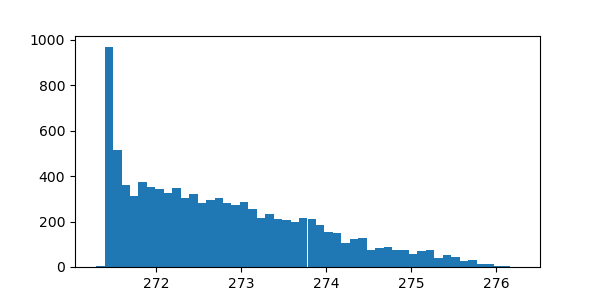

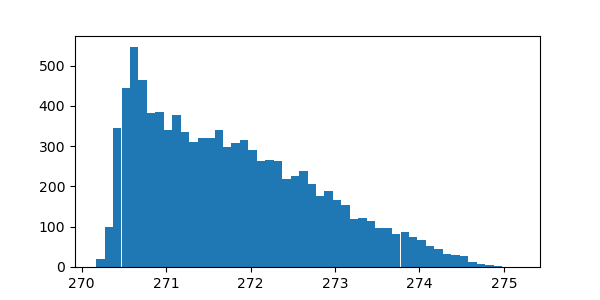

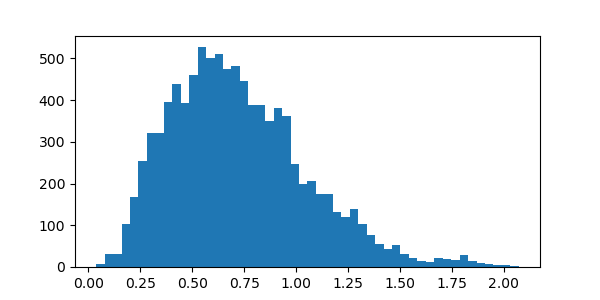

In [35]:
# Create scalar for normalizing T, TOA, and WV data
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
window_dataframes = []

n = 0

for mo in months:
    NLSST_input_file = atmpath / f"TCWV_{mo}.csv"
    if os.path.isfile(NLSST_input_file):
        # print(f"  Month {mo}: NLSST input exists")
        modtran = pd.read_csv(NLSST_input_file)
    else:
        spec_hu_file = f"modtran_atmprofiles_{mo}.txt"
        prefix = f"modtran_atmprofiles_{mo}.bts+tau+dbtdsst.txt"
        modtran = prep_NLSST(atmpath, prefix, spec_hu_file)
        modtran.to_csv(NLSST_input_file, index=False)
    
    # Remove rows with Surface T values of 271.46 and 271.461.
    modtran = modtran[~modtran['Surface T[K]'].isin([271.46, 271.461])]
    
    window_dataframes.append(modtran)
    
    n = n + modtran.shape[0]

# Concatenate the DataFrames for the three months in the window.
modtran_lut = pd.concat(window_dataframes, ignore_index=True)

simTOA = modtran_lut[['TOA T[K]']]
simWV = modtran_lut[['TCWV [cm]']]
# simT = modtran_lut[['Surface T[K]']] # Decided this was skewed because of Andy's forcings so use TOA scaler instead
simT = simTOA.rename(columns={'TOA T[K]': 'Surface T[K]'})

print(f'ERA5 count: {n}')
print(f'Simulated TOA min: {np.around(simTOA.min().values[0],2)}, and max: {np.around(simTOA.max().values[0],2)}')
print(f'Simulated WV min: {np.around(simWV.min().values[0],4)}, and max: {np.around(simWV.max().values[0],5)}')
print(f'Simulated SST min: {np.around(simT.min().values[0],2)}, and max: {np.around(simT.max().values[0],2)}')

simTOA_transformer = StandardScaler().fit(simTOA)
simWV_transformer = StandardScaler().fit(simWV)
# simT_transformer = RobustScaler().fit(simT)
simT_transformer = StandardScaler().fit(simT) # This is using TOA at the moment until get updated TOA


plt.figure(figsize=(6, 3))
plt.hist(modtran_lut['Surface T[K]'], bins=50);

plt.figure(figsize=(6, 3))
plt.hist(modtran_lut['TOA T[K]'], bins=50);

plt.figure(figsize=(6, 3))
plt.hist(modtran_lut['TCWV [cm]'], bins=50);

In [14]:
# Orthoganol distance regression - single month

# # Main loop for processing each month
# months = ['01','02','03','04','05','06','07','08','09','10','11','12']
# atmcor = {}

# for mo in months:
#     print(f'Month: {mo}')
#     NLSST_input_file = atmpath / f'TCWV_{mo}_20230911'
    
#     if os.path.isfile(NLSST_input_file):
#         # print('NLSST input exists')
#         modtran_lut = pd.read_pickle(NLSST_input_file)
#     else:
#         spec_hu_file = f'modtran_atmprofiles_{mo}_20230823.txt'
#         prefix = f'modtran_atmprofiles_{mo}.bts+tau+dbtdsst'
#         # Assume prep_NLSST is defined elsewhere and returns the lookup table DataFrame.
#         modtran_lut = prep_NLSST(atmpath, prefix, spec_hu_file)
#         modtran_lut.to_pickle(NLSST_input_file)
    
#     modtran_lut = modtran_lut[~modtran_lut['Surface T[K]'].isin([271.46, 271.461])]
#         # modtran_lut['Surface T[K]'] = modtran_lut['Surface T[K]']-273.15
    
#     modtran_lut_norm = modtran_lut

#     modtran_lut_norm['Surface T[K]'] = simT_transformer.transform(modtran_lut[['Surface T[K]']])
#     modtran_lut_norm['TOA T[K]'] = simTOA_transformer.transform(modtran_lut[['TOA T[K]']])
#     modtran_lut_norm['TCWV [cm]'] = simWV_transformer.transform(modtran_lut[['TCWV [cm]']])
    
#     # Use the ODR-based regression function in place of the OLS function.
#     odr_results = derive_NLSST_odr(modtran_lut_norm)
    
#     # Round the outputs similar to your previous code:
#     a1 = np.around(odr_results['toa'], 2)
#     a2 = np.around(odr_results['tcwv_toa'], 2)
#     a3 = np.around(odr_results['Intercept'], 2)
        
#     atmcor[mo] = {"a1": a1, "a2": a2, "a3": a3}
#     print(f"Month {mo} coefficients: toa = {a1}, tcwv_toa = {a2}, Intercept = {a3}")

In [14]:
# # Orthoganol distance regression - 3 month rolling window
# months = ['01','02','03','04','05','06','07','08','09','10','11','12']
# atmcor = {}

# # Loop over months by index so we can get the previous and next month via modulo arithmetic.
# for i, middle_month in enumerate(months):
#     # Determine the rolling window months: previous, current, and next (with wrap-around)
#     prev_month = months[(i - 1) % 12]
#     next_month = months[(i + 1) % 12]
#     window_months = [prev_month, middle_month, next_month]
    
#     print(f"Processing rolling window for middle month {middle_month}")
    
#     # Create a list to store the DataFrame for each month in the window.
#     modtran_list = []
    
#     for mo in window_months:
#         NLSST_input_file = atmpath / f'TCWV_{mo}_20230911'
        
#         if os.path.isfile(NLSST_input_file):
#             # print('NLSST input exists')
#             modtran_lut = pd.read_pickle(NLSST_input_file)
#         else:
#             spec_hu_file = f'modtran_atmprofiles_{mo}_20230823.txt'
#             prefix = f'modtran_atmprofiles_{mo}.bts+tau+dbtdsst'
#             # Assume prep_NLSST is defined elsewhere and returns the lookup table DataFrame.
#             modtran_lut = prep_NLSST(atmpath, prefix, spec_hu_file)
#             modtran_lut.to_pickle(NLSST_input_file)

#         modtran_lut = modtran_lut[~modtran_lut['Surface T[K]'].isin([271.46, 271.461])]
#         # modtran_lut['Surface T[K]'] = modtran_lut['Surface T[K]']-273.15

#         modtran_list.append(modtran_lut)

#     # Concatenate the DataFrames for the three months in the window.
#     modtran_lut = pd.concat(modtran_list, ignore_index=True)

#     modtran_lut_norm = modtran_lut

#     modtran_lut_norm['Surface T[K]'] = simT_transformer.transform(modtran_lut[['Surface T[K]']])
#     modtran_lut_norm['TOA T[K]'] = simTOA_transformer.transform(modtran_lut[['TOA T[K]']])
#     modtran_lut_norm['TCWV [cm]'] = simWV_transformer.transform(modtran_lut[['TCWV [cm]']])
    
#     # Use the ODR-based regression function in place of the OLS function.
#     odr_results = derive_NLSST_odr(modtran_lut_norm)
    
#     # Round the outputs similar to your previous code:
#     a1 = np.around(odr_results['toa'], 2)
#     a2 = np.around(odr_results['tcwv_toa'], 2)
#     a3 = np.around(odr_results['Intercept'], 2)
        
#     atmcor[mo] = {"a1": a1, "a2": a2, "a3": a3}
#     print(f"Rolling window ODR regression for month {middle_month}: toa = {a1}, tcwv_toa = {a2}, Intercept = {a3}")

In [15]:
# Ransac regression - single month

# months = ['01','02','03','04','05','06','07','08','09','10','11','12']
# atmcor = {}

# for mo in months:
#     print(f'Month: {mo}')
#     NLSST_input_file = atmpath / f'TCWV_{mo}_20230911'
    
#     if os.path.isfile(NLSST_input_file):
#         # print('NLSST input exists')
#         modtran_lut = pd.read_pickle(NLSST_input_file)
#     else:
#         # Assuming prep_NLSST is defined elsewhere and returns a DataFrame.
#         spec_hu_file = f'modtran_atmprofiles_{mo}_20230823.txt'
#         prefix = f'modtran_atmprofiles_{mo}.bts+tau+dbtdsst'
#         modtran_lut = prep_NLSST(atmpath, prefix, spec_hu_file)
#         modtran_lut.to_pickle(NLSST_input_file)
    
#     modtran_lut = modtran_lut[~modtran_lut['Surface T[K]'].isin([271.46, 271.461])]
#     # modtran_lut['Surface T[K]'] = modtran_lut['Surface T[K]']-273.15

#     modtran_lut_norm = modtran_lut

#     modtran_lut_norm['Surface T[K]'] = simT_transformer.transform(modtran_lut[['Surface T[K]']])
#     modtran_lut_norm['TOA T[K]'] = simTOA_transformer.transform(modtran_lut[['TOA T[K]']])
#     modtran_lut_norm['TCWV [cm]'] = simWV_transformer.transform(modtran_lut[['TCWV [cm]']])
    
#     # Use the RANSAC-based regression function
#     results = derive_NLSST_ransac(modtran_lut_norm, residual_threshold=1.0, max_trials=100, random_state=42)
    
#     # Round the outputs as in your old code:
#     a1 = np.around(results['toa'], 2)
#     a2 = np.around(results['tcwv_toa'], 2)
#     a3 = np.around(results['Intercept'], 2)
    
#     atmcor[mo] = {"a1": a1, "a2": a2, "a3": a3}
#     print(f"Ransac {mo} coefficients: toa = {a1}, tcwv_toa = {a2}, Intercept = {a3}")

In [16]:
# # RANSAC regression - 3 month rolling window
# months = ['01','02','03','04','05','06','07','08','09','10','11','12']
# atmcor = {}

# # Loop over months by index so we can get the previous and next month via modulo arithmetic.
# for i, middle_month in enumerate(months):
#     # Determine the rolling window months: previous, current, and next (with wrap-around)
#     prev_month = months[(i - 1) % 12]
#     next_month = months[(i + 1) % 12]
#     window_months = [prev_month, middle_month, next_month]
    
#     print(f"Processing rolling window for middle month {middle_month}")
    
#     # Create a list to store the DataFrame for each month in the window.
#     modtran_list = []
    
#     for mo in window_months:
#         NLSST_input_file = atmpath / f'TCWV_{mo}_20230911'
        
#         if os.path.isfile(NLSST_input_file):
#             # print('NLSST input exists')
#             modtran_lut = pd.read_pickle(NLSST_input_file)
#         else:
#             # Assuming prep_NLSST is defined elsewhere and returns a DataFrame.
#             spec_hu_file = f'modtran_atmprofiles_{mo}_20230823.txt'
#             prefix = f'modtran_atmprofiles_{mo}.bts+tau+dbtdsst'
#             modtran_lut = prep_NLSST(atmpath, prefix, spec_hu_file)
#             modtran_lut.to_pickle(NLSST_input_file)
        
#         modtran_lut = modtran_lut[~modtran_lut['Surface T[K]'].isin([271.46, 271.461])]
#         # modtran_lut['Surface T[K]'] = modtran_lut['Surface T[K]']-273.15

#         modtran_list.append(modtran_lut)

#     # Concatenate the DataFrames for the three months in the window.
#     modtran_lut = pd.concat(modtran_list, ignore_index=True)

#     modtran_lut_norm = modtran_lut

#     modtran_lut_norm['Surface T[K]'] = simT_transformer.transform(modtran_lut[['Surface T[K]']])
#     modtran_lut_norm['TOA T[K]'] = simTOA_transformer.transform(modtran_lut[['TOA T[K]']])
#     modtran_lut_norm['TCWV [cm]'] = simWV_transformer.transform(modtran_lut[['TCWV [cm]']])
        
#     # Use the RANSAC-based regression function
#     results = derive_NLSST_ransac(modtran_lut_norm, residual_threshold=1.0, max_trials=100, random_state=42)
    
#     # Round the outputs as in your old code:
#     a1 = np.around(results['toa'], 2)
#     a2 = np.around(results['tcwv_toa'], 2)
#     a3 = np.around(results['Intercept'], 2)
    
#     atmcor[middle_month] = {"a1": a1, "a2": a2, "a3": a3}
#     print(f"Rolling window RANSAC regression for month {middle_month}: toa = {a1}, tcwv_toa = {a2}, Intercept = {a3}")

In [17]:
# # Derive NLSST coefficiencts from MODTRAN files by season

# months = [['12','01','02','03','04','05'],['06','07','08','09','10','11']]
# atmcor = {}

# for season in months:
#     # Create an empty list to store modtran DataFrames for the season
#     modtran_list = []
#     for mo in season:
#         print (f'Month: {mo}')
#         NLSST_input_file = atmpath / f'TCWV_{mo}_20230911'
#         if os.path.isfile(NLSST_input_file):
#             print ('NLSST input exists')
#             modtran_lut = pd.read_pickle(NLSST_input_file)
#         else:
#             spec_hu_file = f'modtran_atmprofiles_{mo}_20230823.txt'
#             prefix = f'modtran_atmprofiles_{mo}.bts+tau+dbtdsst'
#             modtran_lut = prep_NLSST(atmpath,prefix,spec_hu_file)
#             modtran_lut.to_pickle(NLSST_input_file)

#         # Append the DataFrame for this month to the list
#         modtran_list.append(modtran_lut)
    
#     # Concatenate all the months' DataFrames for the season
#     modtran_lut = pd.concat(modtran_list, ignore_index=True)

#     modtran_lut_norm = modtran_lut

#     modtran_lut_norm['Surface T[K]'] = simT_transformer.transform(modtran_lut[['Surface T[K]']])
#     modtran_lut_norm['TOA T[K]'] = simTOA_transformer.transform(modtran_lut[['TOA T[K]']])
#     modtran_lut_norm['TCWV [cm]'] = simWV_transformer.transform(modtran_lut[['TCWV [cm]']])
        
#     NLSST_results = derive_NLSST(modtran_lut)
#     a1 = np.around(NLSST_results.params.toa,2)
#     a2 = np.around(NLSST_results.params.tcwv_toa,2)
#     a3 = np.around(NLSST_results.params.Intercept,2)
            
#     atmcor[mo] = {"a1": a1, "a2": a2, "a3": a3}
#     print(f"Linear regress {mo} coefficients: toa = {a1}, tcwv_toa = {a2}, Intercept = {a3}")
#     print(NLSST_results.rsquared)

In [18]:
# # Derive NLSST coefficiencts from MODTRAN files - single month

# months = ['01','02','03','04','05','06','07','08','09','10','11','12']
# atmcor = {}

# for mo in months:
#     print (f'Month: {mo}')
#     NLSST_input_file = atmpath / f'TCWV_{mo}_20230911'
#     if os.path.isfile(NLSST_input_file):
#         # print ('NLSST input exists')
#         modtran_lut = pd.read_pickle(NLSST_input_file)
#     else:
#         spec_hu_file = f'modtran_atmprofiles_{mo}_20230823.txt'
#         prefix = f'modtran_atmprofiles_{mo}.bts+tau+dbtdsst'
#         modtran_lut = prep_NLSST(atmpath,prefix,spec_hu_file)
#         modtran_lut.to_pickle(NLSST_input_file)

#     modtran_lut = modtran_lut[~modtran_lut['Surface T[K]'].isin([271.46, 271.461])]
#     # modtran_lut['Surface T[K]'] = modtran_lut['Surface T[K]']-273.15

#     modtran_lut_norm = modtran_lut

#     modtran_lut_norm['Surface T[K]'] = simT_transformer.transform(modtran_lut[['Surface T[K]']])
#     modtran_lut_norm['TOA T[K]'] = simTOA_transformer.transform(modtran_lut[['TOA T[K]']])
#     modtran_lut_norm['TCWV [cm]'] = simWV_transformer.transform(modtran_lut[['TCWV [cm]']])
    
#     NLSST_results = derive_NLSST(modtran_lut)
#     a1 = np.around(NLSST_results.params.toa,2)
#     a2 = np.around(NLSST_results.params.tcwv_toa,2)
#     a3 = np.around(NLSST_results.params.Intercept,2)
        
#     atmcor[mo] = {"a1": a1, "a2": a2, "a3": a3}
#     print(f"Linear regress {mo} coefficients: toa = {a1}, tcwv_toa = {a2}, Intercept = {a3}, R2 = {NLSST_results.rsquared}")
    
# print(NLSST_results.summary())

# atmcor['02']['a3']=atmcor['03']['a3']
# atmcor['11']['a1']=atmcor['10']['a1']
# atmcor['11']['a3']=atmcor['10']['a3']

In [36]:
# Derive NLSST coefficiencts from MODTRAN files - 3 month rolling window
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
atmcor = {}  # To store the regression results for each middle month.

# Loop over months by index so we can get the previous and next month via modulo arithmetic.
for i, middle_month in enumerate(months):
    # Determine the rolling window months: previous, current, and next (with wrap-around)
    prev_month = months[(i - 1) % 12]
    next_month = months[(i + 1) % 12]
    window_months = [prev_month, middle_month, next_month]
    
    print(f"Processing rolling window for middle month {middle_month}")
    
    # Create a list to store the DataFrame for each month in the window.
    modtran_list = []
    
    for mo in window_months:
        NLSST_input_file = atmpath / f"TCWV_{mo}.csv"
        if os.path.isfile(NLSST_input_file):
            # print(f"  Month {mo}: NLSST input exists")
            modtran_lut = pd.read_csv(NLSST_input_file)
        else:
            spec_hu_file = f"modtran_atmprofiles_{mo}.txt"
            prefix = f"modtran_atmprofiles_{mo}.bts+tau+dbtdsst.txt"
            modtran_lut = prep_NLSST(atmpath, prefix, spec_hu_file)
            modtran.to_csv(NLSST_input_file, index=False)
        
        # Remove rows with Surface T values of 271.46 and 271.461.
        modtran_lut = modtran_lut[~modtran_lut['Surface T[K]'].isin([271.46, 271.461])]
        print(f'{mo}: {modtran_lut.shape[0]}')
        
        modtran_list.append(modtran_lut)
    
    # Concatenate the DataFrames for the three months in the window.
    modtran_lut = pd.concat(modtran_list, ignore_index=True)

    modtran_lut_norm = modtran_lut

    modtran_lut_norm['Surface T[K]'] = simT_transformer.transform(modtran_lut[['Surface T[K]']])
    modtran_lut_norm['TOA T[K]'] = simTOA_transformer.transform(modtran_lut[['TOA T[K]']])
    modtran_lut_norm['TCWV [cm]'] = simWV_transformer.transform(modtran_lut[['TCWV [cm]']])
    
    # Run the regression using your derive_NLSST function on the concatenated DataFrame.
    NLSST_results = derive_NLSST(modtran_lut_norm)
    a1 = np.around(NLSST_results.params.toa, 2)
    a2 = np.around(NLSST_results.params.tcwv_toa, 2)
    a3 = np.around(NLSST_results.params.Intercept, 2)
    r2 = np.around(NLSST_results.rsquared, 2)
    
    pa1 = np.around(NLSST_results.pvalues[1], 3)
    pa2 = np.around(NLSST_results.pvalues[2], 3)
    pa3 = np.around(NLSST_results.pvalues[0], 3)
    
    # Store the regression coefficients and R2 for the middle month.
    atmcor[middle_month] = {"a1": a1, "a2": a2, "a3": a3}
    print(f"Rolling for month {middle_month}: toa = {a1}, tcwv_toa = {a2}, Intercept = {a3}, R2 = {r2}")
    print(f"p-values for month {middle_month}: toa = {pa1}, tcwv_toa = {pa2}, Intercept = {pa3}")

print(NLSST_results.summary())

Processing rolling window for middle month 01
12: 772
01: 1175
02: 1417
Rolling for month 01: toa = 1.08, tcwv_toa = -0.02, Intercept = 0.96, R2 = 0.98
p-values for month 01: toa = 0.0, tcwv_toa = 0.0, Intercept = 0.0
Processing rolling window for middle month 02
01: 1175
02: 1417
03: 1417
Rolling for month 02: toa = 1.08, tcwv_toa = -0.01, Intercept = 0.96, R2 = 0.98
p-values for month 02: toa = 0.0, tcwv_toa = 0.011, Intercept = 0.0
Processing rolling window for middle month 03
02: 1417
03: 1417
04: 1145
Rolling for month 03: toa = 1.07, tcwv_toa = 0.01, Intercept = 0.99, R2 = 0.99
p-values for month 03: toa = 0.0, tcwv_toa = 0.007, Intercept = 0.0
Processing rolling window for middle month 04
03: 1417
04: 1145
05: 958
Rolling for month 04: toa = 1.06, tcwv_toa = 0.01, Intercept = 0.99, R2 = 0.98
p-values for month 04: toa = 0.0, tcwv_toa = 0.0, Intercept = 0.0
Processing rolling window for middle month 05
04: 1145
05: 958
06: 605
Rolling for month 05: toa = 1.05, tcwv_toa = -0.0, In

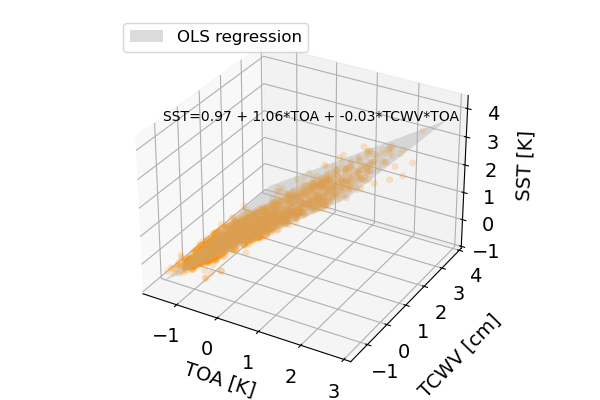

In [37]:
# Plot multiple linear regression in 3D

data = modtran_lut_norm

# Generating predictions for a range of TOA and TCWV values
xi = np.linspace(data['TOA T[K]'].min(), data['TOA T[K]'].max(), 100)
wi = np.linspace(data['TCWV [cm]'].min(), data['TCWV [cm]'].max(), 100)
X, W = np.meshgrid(xi, wi)
Z_pred = NLSST_results.predict(exog=dict(toa=X.ravel(), tcwv_toa=(X*W).ravel())).values.reshape(X.shape)

# Create a figure and a 3D axes
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

ax.tick_params(labelsize=14)
ax.plot_surface(X,W,Z_pred,color='0.8', alpha=0.5,label='OLS regression',zorder=0)
ax.scatter(data['TOA T[K]'],data['TCWV [cm]'],data['Surface T[K]'],color='darkorange',linewidth=0,s=25,alpha=0.2,label='_no label_',zorder=2)
ax.text(-2.8,1,3.0,f'SST={a3} + {a1}*TOA + {a2}*TCWV*TOA',fontsize=10)
# a1.set_ylim([-3,2.5])
# a1.set_xlim([-3,2.5])
ax.set_xlabel('TOA [K]',labelpad=6,fontsize=14)
ax.set_ylabel('TCWV [cm]',labelpad=13,fontsize=14)
ax.set_zlabel('SST [K]',labelpad=6,fontsize=14)
ax.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tashasnow/Library/CloudStorage/GoogleDrive-tsnow03@gmail.com/My\ Drive/GoogleDrivePhD_postdoc/PhD_Project/Manuscripts/LandsatManuscript/Figures/MODTRANretrieval.jpg', format='jpg', dpi=1000)
plt.show()

In [38]:
# # Info on MODIS atmospheric dataset (MOD/MYD07 Level 2)
# from pprint import pprint
# datasets = earthaccess.search_datasets(short_name="MOD07_L2",
#                                        cloud_hosted=True)

# for dataset in datasets:
#     pprint(dataset.summary())

## Acquire MODIS water vapor climatologies to be able to remove land contaminated wv

In [22]:
# start_dt = '2023-02-01'
# end_dt = '2023-03-01'

# # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
# results = earthaccess.search_data(
#     short_name='MOD07_L2',
#     bounding_box=bbox,
#     # Day of a landsat scene to day after - searches day of only
#     temporal=(start_dt,end_dt)
# )
# results2 = earthaccess.search_data(
#     short_name='MYD07_L2',
#     bounding_box=bbox,
#     # Day of a landsat scene to day after - searches day of only
#     temporal=(start_dt,end_dt)
# )
# results = results + results2
# print (f'{len(results)} TOTAL granules')

In [23]:
# # Use these access pathways while S3 streaming is not working
# # data_links = [granule.data_links(access="external") for granule in results[ind:ind+1]]
# netcdf_list = [g._filter_related_links("USE SERVICE API")[0].replace(".html", ".nc4") for g in results]
# # This is going to be slow as we are asking Opendap to format HDF into NetCDF4 so we only processing 3 granules
# # and Opendap is very prone to failures due concurrent connections, not ideal.
# file_handlers = earthaccess.download(netcdf_list,modout_path,provider='NSIDC')

In [24]:
# for modfilenm in file_handlers:
#     os.rename(f'{modfilenm}', f'{modfilenm}.gz')
#     with gzip.open(f'{modfilenm}.gz', 'rb') as f_in:
#         with open(f'{modfilenm}', 'wb') as f_out:
#             f_out.write(f_in.read())
#             os.remove(f'{modfilenm}.gz')

In [25]:
# mod07 = xr.open_dataset(f'{modfilenm}')
# mod07

In [26]:
# import glob

# # # Step 1: Make a list of local NetCDF/HDF files
# # data_files = glob.glob(f'{modout_path}/*.nc4')  

# # Step 2: Load them in one go with xarray
# ds = xr.open_mfdataset(
#     file_handlers,
#     combine='nested',
#     parallel=True,
#     chunks={'time': 1}  # Adjust chunking as needed
# )

# # Now ds is your combined Dataset
# print(ds)

In [27]:
# # 3. Force the data to load into memory
# ds.load()

# # 4. Now you can safely delete the source files
# for f in data_files:
#     os.remove(f)

# # ds is still accessible in memory
# print(ds)

In [28]:
# # Suppose lat = ds['Latitude'], lon = ds['Longitude'], or 
# # you can read an explicit bounding box after georeferencing
# ds_subset = ds.where(
#   (ds.lat >= min_lat) & (ds.lat <= max_lat) &
#   (ds.lon >= min_lon) & (ds.lon <= max_lon),
#   drop=True
# )

In [29]:
# # Convert time dimension to xarray datetime if needed
# ds_subset = ds_subset.resample(time='1W').mean()   # weekly
# # or
# ds_subset = ds_subset.resample(time='1M').mean()   # monthly

In [30]:
# # Example: each monthly step, flatten the spatial dimension
# monthly_distributions = ds_subset.groupby('time').apply(
#     lambda x: np.histogram(x.Water_Vapor.values.ravel(), bins=50)
# )

In [31]:
# ds_climatology.to_netcdf("mod07_climatology.nc")

In [32]:
# modout_path

## Search for desired Landsat scenes

In [33]:
# Search for desired Landsat scenes
items = search_stac(url, collection, gjson_outfile=gjson_outfile, bbox=bbox, timeRange=timeRange)

# Open stac catalog for some needed info
catalog = intake.open_stac_item_collection(items)

# Load the geojson file
gf = gpd.read_file(gjson_outfile)

Searching for items in bbox (-101.98, -75.09, -101.65, -75.05) and timeRange 2021-09-01/2023-04-07
Found 437 item(s)


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


In [34]:
# Plot tiles of all scenes found
plot_search(gf,satellite,colnm)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (landsat:wrs_path,landsat:wrs_row)

**Note the bands you would like to include are assigned by passing the bandNames parameter to landsat_to_xarray using the following codes:**

'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'pan', 'cirrus', 'lwir11', 'lwir12', 'qa_pixel'

## Process Landsat scenes to acquire sea surface temperature

In [35]:
# Convert bounding box to polar for checking if landsat has any data in bounding box
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

sbox,checkbox = lsat_reproj(source_crs,target_crs,(bbox[0],bbox[1],bbox[2],bbox[3]))

# Create polygon for later cropping
polygon = Polygon([(sbox[0][0],sbox[0][1]),(sbox[3][0],sbox[3][1]),(sbox[2][0],sbox[2][1]),(sbox[1][0],sbox[1][1])])

# Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
minx, miny, maxx, maxy = polygon.bounds
polarx = [minx, maxx]
polary = [miny, maxy]

lsat_reproj normal orientation
bbox=[(-1597688.298084341, -339016.2790809458), (-1593366.781037616, -338099.28880761017), (-1595287.654206268, -328916.59785338835), (-1599614.3810303286, -329808.68290341593)]
lbox=(-101.98, -75.09, -101.65, -75.05)
checkbox=[-101.98  -75.09 -101.65  -75.05]


In [36]:
%%time
# ***Problems downloading w earthaccess (tried up one and up down one version) or xarray reading (tried up and down versions, but didn't try other engines like rasterio)
## 1 min 1 sec per image without interpolation, 1 min 5 s with interp, no extra memory 
## With all clusters - 4 min 20 sec @ 15k, 4 min 6 sec @ 10k, 6 min 40 sec @ 5k

# Saves MODIS water vapor file name in COG so know what each image was corrected with

# Include only Landsat 8 scenes
catalog_list = [x for x in items if x.id[3]=='8']

for sceneid in tqdm(catalog_list, desc="Processing"):
    print(sceneid.id)
    
    scene = catalog[sceneid.id]
    timestr = scene.metadata['datetime'].strftime('%H%M%S')

    outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'
    
    if os.path.isfile(outFile):
        print (f'{sceneid.id} - atm corr exists')

    else:
        # Open all desired bands for one scene
        ls_scene = landsat_to_xarray(sceneid,catalog)
        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

        # Create classification mask
        ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)
        
        try:
            # Check for any open ocean pixels in bounding box - go to next image if none - 9.3 s
            mask = np.ones(ls_scene.shape[1:])
            mask[ls_scene.mask!=3] = np.nan
            ls_thermal = ls_scene.sel(band='lwir11').compute()
            ls_box = subset_img(ls_thermal*mask,polarx,polary)
            # ls_box = (ls_thermal*mask).sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))
            # ls_box = ls_box.where(ls_box >= -3.5, np.nan)
    
            if ((ls_box).notnull()).sum().values==0:
                print (f'{sceneid.id} has no SSTs')
                try:
                    del ls_scene, scene, mask, ls_thermal, ls_box
                except:
                    pass
                gc.collect()
                continue
                
            # Use band ratios for RF cloud pixel classification
            # ###
    
            # Atmospheric correction using MODIS
            # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
            mod07,modfilenm = open_MODIS(ls_scene,scene,modout_path)
    
            # Create water vapor files aligned and subsampled to Landsat
            spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long, 1 must be negative for MODISlookup
    
            #***has not yet been tested to ensure no interp works properly
            WV_xr = get_wv(ls_scene,mod07,spacing,WV,scene,interp=interp)
    
            # Create SST by masking and using water vapor to apply month-specific atmospheric correction
            SST = apply_NLSST(ls_thermal,scene,mask,WV_xr,atmcor,simT_transformer,simTOA_transformer,simWV_transformer)
    
            # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
            # data variables in COG (click on white paper info button in xarray readout)
            SST.attrs['MODIS_WV'] = modfilenm
    
            print (f'Mean SST: {np.nanmean(SST)}')
    
            # Save to a cloud-optimized Geotiff
            SST.rio.to_raster(raster_path=outFile, driver="COG")
                
        except Exception as e:
            print (f'{sceneid.id} has no SSTs: {e}')
        
        try:
            del ls_scene, scene, ls_thermal, ls_box, mod07, WV_xr, SST
        except:
            pass
        
        gc.collect()

Processing:   0%|          | 0/189 [00:00<?, ?it/s]

LC08_L1GT_158131_20230105_20230110_02_T2
(337, 208)
LC08_L1GT_158131_20230105_20230110_02_T2 has no SSTs


Processing:   1%|          | 1/189 [00:33<1:44:13, 33.26s/it]

LC08_L1GT_231114_20230104_20230111_02_T2
(337, 208)
23 TOTAL granules
TopologyException: side location conflict at -56.425601506966906 -70.302205314361174. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -67.33514591288646 -75.40722042814356. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -74.984631536203551 -71.229299498920639. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -30.819964438574551 -71.659516342074824. This can occur if the input geometry is invalid.
1 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:40:54


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 1811 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MOD07_L2.A2023004.1615.061.2023136145148.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.0003742951285040811, min: 0.00034, max: 0.0004
Mean SST: -7.172643542238897


Processing:   1%|          | 2/189 [02:29<4:16:31, 82.31s/it]

LC08_L1GT_160130_20230103_20230111_02_T2
(337, 208)
LC08_L1GT_160130_20230103_20230111_02_T2 has no SSTs


Processing:   2%|▏         | 3/189 [02:59<3:00:56, 58.37s/it]

LC08_L1GT_233114_20230102_20230111_02_T2
(337, 208)
LC08_L1GT_233114_20230102_20230111_02_T2 has no SSTs


Processing:   2%|▏         | 4/189 [03:28<2:23:55, 46.68s/it]

LC08_L1GT_233113_20230102_20230111_02_T2
(337, 208)
LC08_L1GT_233113_20230102_20230111_02_T2 has no SSTs


Processing:   3%|▎         | 5/189 [04:03<2:10:33, 42.57s/it]

LC08_L1GT_002113_20221231_20230110_02_T2
(337, 208)
LC08_L1GT_002113_20221231_20230110_02_T2 has no SSTs


Processing:   3%|▎         | 6/189 [04:32<1:55:18, 37.81s/it]

LC08_L1GT_157131_20221229_20230104_02_T2
(337, 208)
LC08_L1GT_157131_20221229_20230104_02_T2 has no SSTs


Processing:   4%|▎         | 7/189 [05:05<1:49:41, 36.16s/it]

LC08_L1GT_159131_20221227_20230113_02_T2
(337, 208)
LC08_L1GT_159131_20221227_20230113_02_T2 has no SSTs


Processing:   4%|▍         | 8/189 [05:36<1:44:41, 34.70s/it]

LC08_L1GT_159130_20221227_20230113_02_T2
(337, 208)
LC08_L1GT_159130_20221227_20230113_02_T2 has no SSTs


Processing:   5%|▍         | 9/189 [06:08<1:41:09, 33.72s/it]

LC08_L1GT_232114_20221226_20230113_02_T2
(337, 208)
20 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -23.167011672691366 -75.436754390792487. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -109.20722925500593 -70.475928501674773. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -76.539931996098446 -71.308178065070749. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -31.59059268198445 -71.801996227840334. This can occur if the input geometry is invalid.
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:19:44


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 2848 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MOD07_L2.A2022360.1500.061.2022362015854.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.000625009266779117, min: 0.00044, max: 0.0007
Mean SST: -2.587343979412327


Processing:   5%|▌         | 10/189 [08:02<2:54:29, 58.49s/it]

LC08_L1GT_232113_20221226_20230113_02_T2
(337, 208)
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -23.167011672691366 -75.436754390792487. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -76.539931996098446 -71.308178065070749. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -31.59059268198445 -71.801996227840334. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:20:08


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 2848 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MOD07_L2.A2022360.1500.061.2022362015854.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.0006418351729631314, min: 0.00041, max: 0.00071
Mean SST: -2.150334068542748


Processing:   6%|▌         | 11/189 [09:59<3:47:09, 76.57s/it]

LC08_L1GT_001113_20221224_20230103_02_T2
(337, 208)
21 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -67.105543073943934 -74.160475351082667. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:22:47


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 3754 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MOD07_L2.A2022358.1515.061.2022359022020.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.00014392478153820302, min: 0.00013, max: 0.00025
Mean SST: -2.2039130560022064


Processing:   6%|▋         | 12/189 [11:54<4:19:40, 88.03s/it]

LC08_L1GT_156131_20221222_20230113_02_T2
(337, 208)
21 TOTAL granules
TopologyException: side location conflict at -12.291696863336169 -72.905551634760272. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -101.96495185082078 -67.384935058026343. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:17:39


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 4778 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MYD07_L2.A2022356.0715.061.2022356195706.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.000518837602704159, min: 0.00025, max: 0.00059
Mean SST: -2.1862506132778847


Processing:   7%|▋         | 13/189 [13:58<4:50:27, 99.02s/it]

LC08_L1GT_158131_20221220_20221227_02_T2
(337, 208)
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -53.985509030891443 -71.871190169657083. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -28.363877292589248 -74.035043343061972. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -106.04635100207187 -69.724617946759494. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 02:44:45


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 3730 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MOD07_L2.A2022354.0425.061.2022355175008.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.000343523737604897, min: 0.00026, max: 0.00044
Mean SST: -3.2110975630703074


Processing:   7%|▋         | 14/189 [15:57<5:06:45, 105.18s/it]

LC08_L1GT_231114_20221219_20230113_02_T2
(337, 208)
LC08_L1GT_231114_20221219_20230113_02_T2 has no SSTs


Processing:   8%|▊         | 15/189 [16:27<3:59:15, 82.50s/it] 

LC08_L1GT_160131_20221218_20230113_02_T2
(337, 208)
LC08_L1GT_160131_20221218_20230113_02_T2 has no SSTs


Processing:   8%|▊         | 16/189 [17:00<3:14:57, 67.62s/it]

LC08_L1GT_160130_20221218_20230113_02_T2
(337, 208)
22 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -9.7609720011497956 -75.830123100127196. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -96.580702576866102 -70.774214162162494. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -39.28510116499384 -71.386496563013054. This can occur if the input geometry is invalid.
2 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 02:41:44


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 3614 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MOD07_L2.A2022352.0440.061.2022354214751.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.00025135872098443077, min: 0.00022, max: 0.00028
Mean SST: -7.509023072897799


Processing:   9%|▉         | 17/189 [19:06<4:04:12, 85.19s/it]

LC08_L1GT_233114_20221217_20221227_02_T2
(337, 208)
LC08_L1GT_233114_20221217_20221227_02_T2 has no SSTs


Processing:  10%|▉         | 18/189 [19:37<3:16:12, 68.84s/it]

LC08_L1GT_233113_20221217_20221227_02_T2
(337, 208)
LC08_L1GT_233113_20221217_20221227_02_T2 has no SSTs


Processing:  10%|█         | 19/189 [20:07<2:42:18, 57.28s/it]

LC08_L1GT_002113_20221215_20221227_02_T2
(337, 208)
LC08_L1GT_002113_20221215_20221227_02_T2 has no SSTs


Processing:  11%|█         | 20/189 [20:38<2:18:38, 49.22s/it]

LC08_L1GT_157131_20221213_20221219_02_T2
(337, 208)
LC08_L1GT_157131_20221213_20221219_02_T2 has no SSTs


Processing:  11%|█         | 21/189 [21:16<2:08:23, 45.85s/it]

LC08_L1GT_159131_20221211_20221219_02_T2
(337, 208)
LC08_L1GT_159131_20221211_20221219_02_T2 has no SSTs


Processing:  12%|█▏        | 22/189 [21:50<1:57:56, 42.38s/it]

LC08_L1GT_159130_20221211_20221219_02_T2
(337, 208)
LC08_L1GT_159130_20221211_20221219_02_T2 has no SSTs


Processing:  12%|█▏        | 23/189 [22:28<1:53:12, 40.92s/it]

LC08_L1GT_232114_20221210_20221219_02_T2
(337, 208)
LC08_L1GT_232114_20221210_20221219_02_T2 has no SSTs


Processing:  13%|█▎        | 24/189 [22:59<1:44:11, 37.89s/it]

LC08_L1GT_232113_20221210_20221219_02_T2
(337, 208)
LC08_L1GT_232113_20221210_20221219_02_T2 has no SSTs


Processing:  13%|█▎        | 25/189 [23:27<1:36:08, 35.18s/it]

LC08_L1GT_001113_20221208_20221213_02_T2
(337, 208)
LC08_L1GT_001113_20221208_20221213_02_T2 has no SSTs


Processing:  14%|█▍        | 26/189 [23:58<1:32:16, 33.96s/it]

LC08_L1GT_003113_20221206_20221212_02_T2
(337, 208)
LC08_L1GT_003113_20221206_20221212_02_T2 has no SSTs


Processing:  14%|█▍        | 27/189 [24:36<1:34:27, 34.99s/it]

LC08_L1GT_156131_20221206_20230113_02_T2
(337, 208)
LC08_L1GT_156131_20221206_20230113_02_T2 has no SSTs


Processing:  15%|█▍        | 28/189 [25:15<1:37:35, 36.37s/it]

LC08_L1GT_158131_20221204_20230113_02_T2
(337, 208)
20 TOTAL granules
TopologyException: side location conflict at -35.826824571928185 -71.87234810116793. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -47.004652136609685 -74.688498166856121. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:25:06


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 6737 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MYD07_L2.A2022338.0735.061.2022338192751.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.0003334300777827569, min: 0.00016, max: 0.00041
Mean SST: -2.58901678153341


Processing:  15%|█▌        | 29/189 [28:21<3:36:00, 81.00s/it]

LC08_L1GT_231114_20221203_20221212_02_T2
(337, 208)
20 TOTAL granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
TopologyException: side location conflict at -106.36457721410059 -71.36767048404937. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:00:45


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 6646 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MOD07_L2.A2022337.1535.061.2022350091400.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.00022203323686749101, min: 0.00021, max: 0.00025
Mean SST: -3.2336296811708602


Processing:  16%|█▌        | 30/189 [30:22<4:06:38, 93.07s/it]

LC08_L1GT_160130_20221202_20221212_02_T2
(337, 208)
22 TOTAL granules
TopologyException: side location conflict at 7.1176852385874394 -75.756262165718852. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -79.509108039813214 -70.720946242456833. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -61.522444603970889 -71.722569581218067. This can occur if the input geometry is invalid.
1 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 10:56:52


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 5002 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MYD07_L2.A2022335.2025.061.2022336171231.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.0002831489800313866, min: 0.00016, max: 0.00035
Mean SST: -10.844339981103081


Processing:  16%|█▋        | 31/189 [33:00<4:56:34, 112.62s/it]

LC08_L1GT_233114_20221201_20221212_02_T2
(337, 208)
22 TOTAL granules
TopologyException: side location conflict at -52.637580899682888 -70.079157845645327. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -65.105512103215929 -75.036208840193055. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -26.862190378390434 -75.786053629570958. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -108.1640073080474 -71.088187536323659. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 05:38:23


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 5002 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MYD07_L2.A2022335.2025.061.2022336171231.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.00031855806406260964, min: 0.00025, max: 0.00033
Mean SST: -2.641104714093231


Processing:  17%|█▋        | 32/189 [35:26<5:20:37, 122.53s/it]

LC08_L1GT_233113_20221201_20221212_02_T2
(337, 208)
21 TOTAL granules
TopologyException: side location conflict at -52.637580899682888 -70.079157845645327. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -65.105512103215929 -75.036208840193055. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -26.862190378390434 -75.786053629570958. This can occur if the input geometry is invalid.
A granule has messed up polygon that likely crosses the International DateLine
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:03:47


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 5740 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MOD07_L2.A2022335.1550.061.2022350021952.hdf.nc4']
y resample reversed
Latitude in proper position
Mean water vapor value is: 0.00028174305291219897, min: 0.00015, max: 0.0003
Mean SST: -2.5431710323830004


Processing:  17%|█▋        | 33/189 [37:29<5:19:26, 122.86s/it]

LC08_L1GT_002113_20221129_20221206_02_T2
(337, 208)
19 TOTAL granules
TopologyException: side location conflict at -13.337467405385688 -73.505667359824656. This can occur if the input geometry is invalid.
3 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 06:03:35


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 4661 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


['MYD07_L2.A2022333.0855.061.2022333210509.hdf.nc4']
y resample reversed
Latitude in proper position


Processing:  17%|█▋        | 33/189 [39:11<3:05:16, 71.26s/it] 
2025-06-13 23:27:08,402 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/base_events.py", line 654, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/nanny.py", line 985, in run
    await worker.finished()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/core.py", line 494, in finished
    await self._event_finished.wait()
  File "/srv/conda/envs/notebook/lib/pyt

KeyboardInterrupt: 

In [ ]:
# # Get spatial extent of Landsat scene in lat/lon
# mbbox = (scene.metadata['bbox'][0], scene.metadata['bbox'][1], scene.metadata['bbox'][2], scene.metadata['bbox'][3]) #(west, south, east, north) 
# lsatpoly = Polygon([(mbbox[0],mbbox[1]),(mbbox[0],mbbox[3]),(mbbox[2],mbbox[3]),(mbbox[2],mbbox[1]),(mbbox[0],mbbox[1])]) # ensure full lineup between landsat and modis

# ls_time = pd.to_datetime(ls_scene.time.values)
# calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
# start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
# end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')

# # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
# results = earthaccess.search_data(
#     short_name='MOD07_L2',
#     bounding_box=mbbox,
#     # Day of a landsat scene to day after - searches day of only
#     temporal=(start_dt,end_dt)
# )
# results2 = earthaccess.search_data(
#     short_name='MYD07_L2',
#     bounding_box=mbbox,
#     # Day of a landsat scene to day after - searches day of only
#     temporal=(start_dt,end_dt)
# )
# results = results + results2
# print (f'{len(results)} TOTAL granules')

# # Accept only granules that overlap at least 100% with Landsat (percent_dif<0.1 is the other option)
# best_grans = []
# for granule in results:
#     try:
#         granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
#     except Exception as error:
#         print(error)
#         continue
#     for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
#         try:
#             map_points = [(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']]
#             pgon = Polygon(map_points)
#             percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
#             if percent_dif < 0.1:
#                 if crosses_idl(map_points):
#                     print (f'A granule has messed up polygon that likely crosses the International DateLine')
#                 else:
#                     best_grans.append(granule)
#                     continue
#         except Exception as error:
#             print(error)
#             # Would love to raise an exception for a valueerror except for GEOSError but not sure how 
# print(f'{len(best_grans)} TOTAL granules w overlap')

# # Find MODIS image closest in time to the Landsat image
# Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
# ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(pd.to_datetime(ls_time)))))
# print(f'Time difference between MODIS and Landsat: {abs(Mdates[ind] - pytz.utc.localize(pd.to_datetime(ls_time)))}')

# # Download MODIS data if needed

# # This doesn't work because xarray can't open legacy HDF EOS data formats
# mod07 = xr.open_mfdataset(earthaccess.open(results))

# # Use these access pathways while S3 streaming is not working
# data_links = [granule.data_links(access="external") for granule in best_grans[ind:ind+1]]
# netcdf_list = [g._filter_related_links("USE SERVICE API")[0].replace(".html", ".nc4") for g in best_grans[ind:ind+1]]
# # This is going to be slow as we are asking Opendap to format HDF into NetCDF4 so we only processing 3 granules
# # and Opendap is very prone to failures due concurrent connections, not ideal.
# file_handlers = earthaccess.download(netcdf_list,modout_path,provider='NSIDC')

# # Open MODIS data
# mod_list = os.listdir(modout_path)
# mod_list = [file for file in mod_list if file[-3:]=='nc4']
# print(mod_list)
# modfilenm = mod_list[0]

# mod07 = xr.open_dataset(f'{modout_path}/{modfilenm}')
#                         # ['netcdf4', 'h5netcdf', 'scipy', 'kerchunk', 'rasterio', 'zarr']
# mod07 = mod07.rio.write_crs('epsg:4326')

# # Delete MODIS file
# os.remove(f'{modout_path}/{modfilenm}')

In [ ]:
def plot_geotiff(filepath):
    # Open the geotiff file
    with rasterio.open(filepath) as src:
        # Reproject the dataset to lat/lon
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': 'EPSG:4326',
            'transform': transform,
            'width': width,
            'height': height
        })

        # Read the data and reproject
        with rasterio.MemoryFile() as memfile:
            with memfile.open(**kwargs) as dst:
                rasterio.warp.reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:4326',
                    resampling=rasterio.enums.Resampling.nearest
                )
                data = dst.read(1)

    # Plot the data
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.imshow(data, transform=ccrs.PlateCarree(), origin='upper', extent=dst.bounds, cmap='viridis')
    ax.set_title(os.path.basename(filepath))
    plt.show()

def create_geotiff_dropdown(directory):
    # Create a dropdown widget with all GeoTIFF files in the directory
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    dropdown = Dropdown(options=tif_files, description='Select a file:')
    
    # Update function to plot based on the selected file
    def update_plot(selected_file):
        plot_geotiff(os.path.join(directory, selected_file))
    
    interact(update_plot, selected_file=dropdown)

# Use the function with your directory path
create_geotiff_dropdown(SSTpath)

In [32]:
wv2 = mask*WV_xr.values

# # Get rid of low outliers from over ice, cutoff for 98.5%
# outlier = np.quantile(wv2[np.isfinite(wv2)],0.01)
# mask2 = np.ones(wv2.shape)
# mask2[wv2<outlier] = np.nan

# wv3 = mask2*wv2
wv3 = np.around(wv2,decimals=5)

means = np.nanmean(wv3)
print (f'Mean water vapor value is: {means}, min: {np.nanmin(wv3)}, max: {np.nanmax(wv3)}')

# Select appropriate atmospheric correction coefficients
month = scene.metadata['datetime'].month
a_mo = f'{2}'.zfill(2)
a1 = atmcor[a_mo]['a1']
a2 = atmcor[a_mo]['a2']
a3 = atmcor[a_mo]['a3']


Mean water vapor value is: 0.0006673100996691812, min: 0.00032, max: 0.00074


In [33]:
# Calculate radiances using MTL data
s3 = boto3.client("s3")

# Extract bucket and key for json MTL file
# Example: bucket = "usgs-landsat" ; key = "collection02/level-1/standard/oli-tirs/2019/002/113/LC08_L1GT_002113_20190206_20201016_02_T2/LC08_L1GT_002113_20190206_20201016_02_T2_MTL.json"
s3_url = scene['MTL.json'].metadata['alternate']['s3']['href']
bucket = s3_url.split('/')[2].strip()
key = s3_url.split(bucket)[1].strip()[1:]

# Get MLT data
res = s3.get_object(Bucket=bucket, Key=key, RequestPayer="requester")
MTL = res["Body"].read().decode("utf-8")

# Get important constants from MTL
ind = MTL.find('K1_CONSTANT_BAND_10')
K1_10 = float(MTL[ind+23:ind+31])
ind = MTL.find('K2_CONSTANT_BAND_10')
K2_10 = float(MTL[ind+23:ind+32])
ind = MTL.find('RADIANCE_MULT_BAND_10')
ML10 = float(MTL[ind+25:ind+35])
ind = MTL.find('RADIANCE_ADD_BAND_10')
AL10 = float(MTL[ind+24:ind+31])

# Mask no data 
DN_masked = ls_thermal.where(ls_thermal != 0)

# Top of Atmosphere radiance for Band 10
Llambda = ML10 * DN_masked + AL10

# Top of Atmosphere brightness temperature for Band 10
T10 = K2_10 / np.log((K1_10 / Llambda) + 1)

In [34]:
T10 = mask * T10
toa=T10
# SST = a3 + a1*toa + a2*wv3*toa - 273.15
# SST = SST.compute()

In [47]:
# Convert toa DataArray to numpy, preserving shape.
toa_arr = toa.values
original_toa_shape = toa_arr.shape
# Reshape to a column vector for the transformer
toa_norm = simTOA_transformer.transform(toa_arr.reshape(-1, 1))
toa_norm = toa_norm.reshape(original_toa_shape)

# Convert wv DataArray to numpy array and transform similarly.
original_wv_shape = wv3.shape
wv_norm = simWV_transformer.transform(wv3.reshape(-1, 1))
wv_norm = wv_norm.reshape(original_wv_shape)

# Calculate normalized SST using the NLSST coefficients and water vapor
SST_norm = a3 + a1 * toa_norm + a2 * wv_norm * toa_norm

# Inverse transform SST: again reshape as needed.
original_sst_shape = SST_norm.shape
SST_norm_flat = SST_norm.reshape(-1, 1)
SST_flat = simT_transformer.inverse_transform(SST_norm_flat)
SST = SST_flat.reshape(original_sst_shape) - 273.15

# Optionally, convert the result back into an xarray.DataArray,
# preserving the original toa coordinates and dimensions:
SST = xr.DataArray(SST, coords=toa.coords, dims=toa.dims)

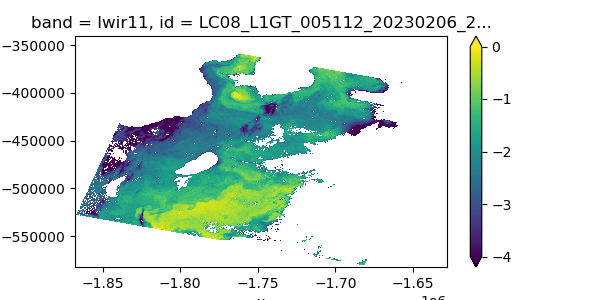

In [51]:
# January atm correction
plt.figure(figsize=(6, 3))
(SST).plot.imshow(x='x',y='y',vmin=-4,vmax=0)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([11223.        , 11977.09960938, 12731.20019531, 13485.29980469,
        14239.40039062, 14993.5       , 15747.59960938, 16501.69921875,
        17255.80078125, 18009.90039062, 18764.        ]),
 <a list of 7991 BarContainer objects>)

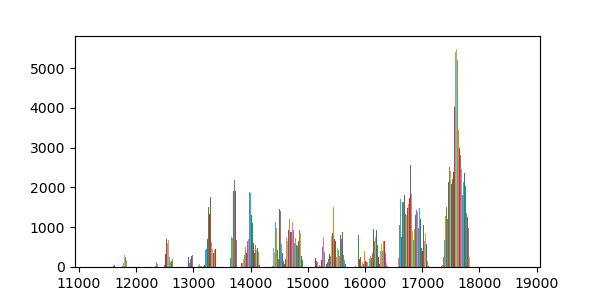

In [23]:
plt.figure(figsize=(6, 3))
plt.hist(DN_masked)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([261.53265381, 262.62966919, 263.72668457, 264.82369995,
        265.92071533, 267.01773071, 268.11474609, 269.21176147,
        270.30877686, 271.40579224, 272.50280762]),
 <a list of 7991 BarContainer objects>)

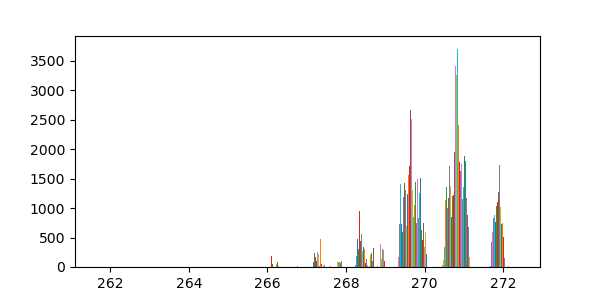

In [22]:
plt.figure(figsize=(6, 3))
plt.hist(toa)

In [32]:
for mo in ['05','11']:
    # Select appropriate atmospheric correction coefficients
    a_mo = mo
    a1 = atmcor[a_mo]['a1']
    a2 = atmcor[a_mo]['a2']
    a3 = atmcor[a_mo]['a3']
    print (f'{mo}: {a3 + a1*np.nanmean(toa) + a2*np.nanmean(wv3)*np.nanmean(toa) - 273.15}')
# Linear

05: -2.2590351534010438
11: -2.772665537320961


AttributeError: 'NoneType' object has no attribute 'plot'

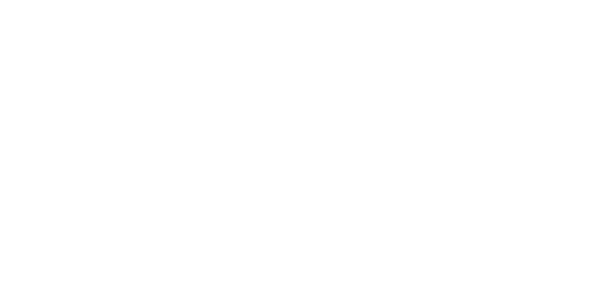

In [31]:
# Feb atm correction
plt.figure(figsize=(6, 3))
(SST).plot.imshow(x='x',y='y',vmin=-4,vmax=0)

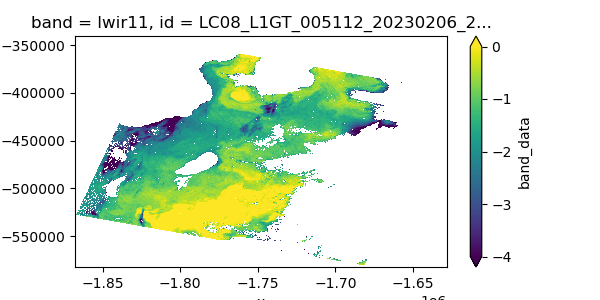

In [185]:
# January atm correction
plt.figure(figsize=(6, 3))
(SST).plot.imshow(x='x',y='y',vmin=-4,vmax=0)

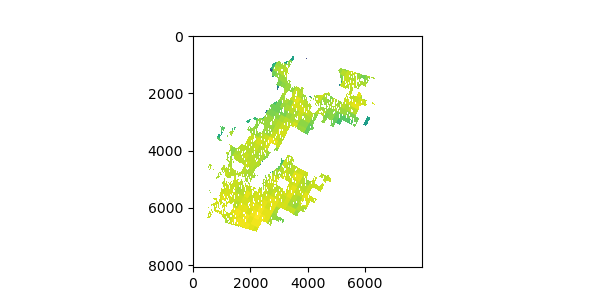

In [33]:
# no interpolation
plt.figure(figsize=(6, 3))
plt.imshow(wv0)

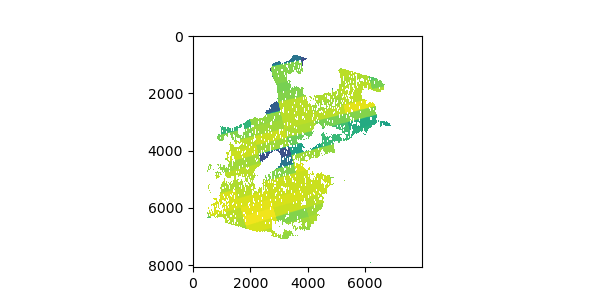

In [60]:
# no interpolation but remove 4% data
plt.figure(figsize=(6, 3))
plt.imshow(wv1)

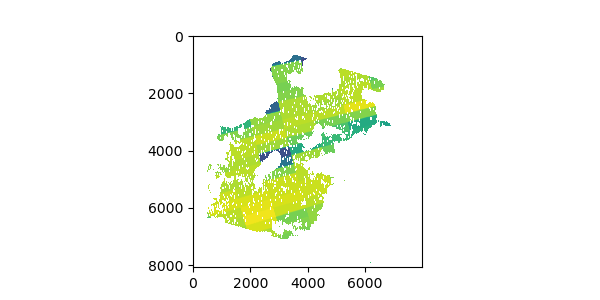

In [80]:
# Interpololation without masking
plt.figure(figsize=(6, 3))
# (ls_thermal*mask).plot.imshow(x='x',y='y')
# (SST).plot.imshow(x='x',y='y')
# (mod07.Water_Vapor).plot.pcolormesh(x='Longitude',y='Latitude')
# (ls_scene.sel(band='qa_pixel').compute()*mask).plot.imshow(x='x',y='y')
plt.imshow(wv3)

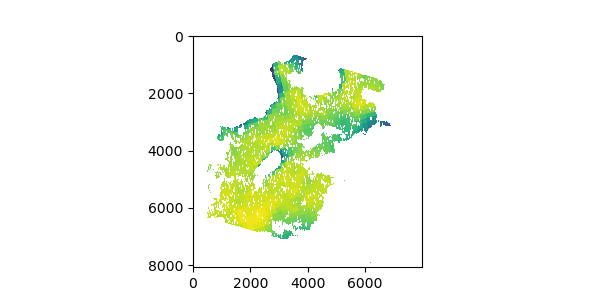

In [144]:
# Interpolation with masking
plt.figure(figsize=(6, 3))
plt.imshow(wv4)

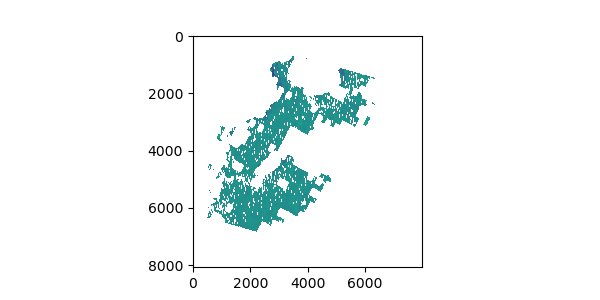

In [164]:
plt.figure(figsize=(6, 3))
plt.imshow(wv4-wv0)

In [163]:
np.unique(wv4-wv0,return_counts=True)

(array([-3.7e-04, -3.6e-04, -3.5e-04, -3.4e-04, -3.4e-04, -3.3e-04,
        -3.3e-04, -3.3e-04, -3.2e-04, -3.2e-04, -3.1e-04, -3.1e-04,
        -3.1e-04, -3.0e-04, -3.0e-04, -2.9e-04, -2.9e-04, -2.9e-04,
        -2.8e-04, -2.8e-04, -2.7e-04, -2.7e-04, -2.7e-04, -2.6e-04,
        -2.6e-04, -2.5e-04, -2.5e-04, -2.5e-04, -2.4e-04, -2.4e-04,
        -2.4e-04, -2.3e-04, -2.3e-04, -2.3e-04, -2.2e-04, -2.2e-04,
        -2.2e-04, -2.1e-04, -2.1e-04, -2.1e-04, -2.0e-04, -2.0e-04,
        -2.0e-04, -2.0e-04, -1.9e-04, -1.9e-04, -1.9e-04, -1.8e-04,
        -1.8e-04, -1.8e-04, -1.7e-04, -1.7e-04, -1.7e-04, -1.6e-04,
        -1.6e-04, -1.6e-04, -1.6e-04, -1.5e-04, -1.5e-04, -1.5e-04,
        -1.4e-04, -1.4e-04, -1.4e-04, -1.3e-04, -1.3e-04, -1.2e-04,
        -1.2e-04, -1.2e-04, -1.2e-04, -1.1e-04, -1.1e-04, -1.1e-04,
        -1.0e-04, -1.0e-04, -1.0e-04, -9.0e-05, -9.0e-05, -9.0e-05,
        -8.0e-05, -8.0e-05, -8.0e-05, -8.0e-05, -7.0e-05, -7.0e-05,
        -7.0e-05, -6.0e-05, -6.0e-05, -6.0e-05, 

In [ ]:
# Plot water vapor data ***need to comment out the delete code above for this to work
data0 = ls_thermal*mask
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(data0.x,data0.y,data0.values,vmin=14000,vmax=17800,transform=cartopy.crs.epsg(3031))
ax.coastlines()
ax.set_ylim([-78, -72])
ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()

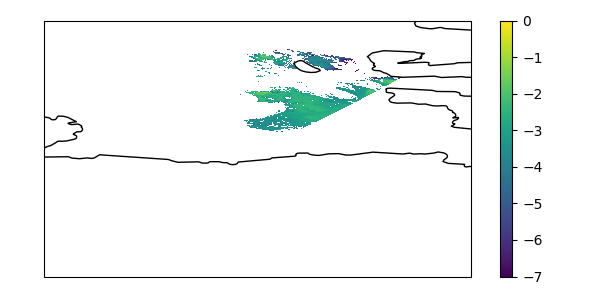

In [29]:
# Plot water vapor data ***need to comment out the delete code above for this to work
data0 = SST
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(data0.x,data0.y,data0.values,vmin=-7,vmax=0,transform=cartopy.crs.epsg(3031))
ax.coastlines()
ax.set_ylim([-78, -72])
ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()

# Create validation matchups via GHRSST iQUAM data
https://www.star.nesdis.noaa.gov/socd/sst/iquam/?tab=0&dateinput_year=2023&dateinput_month=02&dayofmoninput_day=26&dateinput_hour=00&dayofmon=monthly&qcrefsst=_qcrey&qcrefsst=_qccmc&outlier=qced#qmap

In [21]:
# Landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# Paths
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
lsatpath = basepath / 'Data'
atmpath = lsatpath / 'AtmCorrection'
modout_path = lsatpath / 'MOD07_L2'
SSTpath = lsatpath / 'SST/Validation/iQuamIntercomp/'
iQpath = lsatpath / 'iQuam'

WV = 'Water_Vapor'

# For geopandas and tile plots
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}_iQuam.geojson'

# Buffer around iquam point used to create a bounding box for Landsat sample
dist = 1.0 # km

# Temporal search range (days) before/after iquam measurement for finding Landsat image
time_add = 0.5

lthresh = -1.9

interp = 1

In [28]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [29]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [30]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/36825/status,
Dashboard: /user/tsnow03/proxy/36825/status,Workers: 4
Total threads: 4,Total memory: 29.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43507,Workers: 4
Dashboard: /user/tsnow03/proxy/36825/status,Total threads: 4
Started: Just now,Total memory: 29.67 GiB
Comm: tcp://127.0.0.1:33335,Total threads: 1
Dashboard: /user/tsnow03/proxy/37025/status,Memory: 7.42 GiB
Nanny: tcp://127.0.0.1:43823,


In [31]:
# Year and months desired (multiple years)
start_yr = 2013
end_yr = 2015

# Note these will get months from the later part of the year to early next
start_mo = '09'
end_mo = '03'

# Headers for the saved outputs
headers = ['DateTime','L8_filename','L8_SST','L8_std','center','N','S','E','W','NE','SE','NW','SW','L8_SST_max','L8_SST_min','Argo_id','Argo_SST','A_lat','A_lon']

# Desired projection transformation
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the Landsat file

In [ ]:
%%time

# Multiple years

# Set up projections
transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Get iQuam file paths in directory between desired dates and find and produce matching Landsat SSTs 
for year in range(start_yr, end_yr):  
    yrmo = []
    start_yrmo = f"{year}{start_mo}"  # Start from September of the current year
    end_yrmo = f"{year+1}{end_mo}"  # End in March of the next year

    m0 = start_yrmo
    
    # Make a list of months between start and end
    while int(m0) <= int(end_yrmo):
        calc_dt = datetime.strptime(f'{m0[:4]}-{m0[4:]}', '%Y-%m')
        yrmo.append(calc_dt.strftime("%Y%m"))
        m0 = (calc_dt + relativedelta(months=1)).strftime("%Y%m")
    
    # Get file names and select only those matching dates from yrmo    
    iQfiles = os.listdir(iQpath)
    iQfiles = [x for x in iQfiles if x[:6] in yrmo]
    iQfiles.sort(reverse=True)
    print (f'{year}: {len(iQfiles)}')
    
    os.chdir(iQpath)

    # For each iquam file, pair West Antarctic Argo buoy data with Landsat data and create calibrated SSTs
    valid = []
    
    for iquam_file in iQfiles:
        # Open Argos data from iQuam file
        df = xr.open_dataset(iquam_file)
        iquam = df.to_dataframe()
        
        # Subset to Antarctica
        ant = iquam[(iquam.lat<-65)&(iquam.lon>-142)&(iquam.lon<-72)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)]  # Entire West Antarctica (later)
        # ant = iquam[(iquam.lat<-69)&(iquam.lon>-125)&(iquam.lon<-98)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)] # Amundsen Sea
        
        # To remove a landsat day that is coming up with a 403 error
        if ant['year'].iloc[0] == 2020 and ant['month'].iloc[0] == 12:
            ant = ant[ant.day != 9.0] # for 202012 because otherwise will fail
        
        print('')
        print(f'{iquam_file[:6]}: {ant.shape[0]} measurements')
    
        for idx in range(ant.shape[0]):
    
            # Create search area
            ilat = ant['lat'].iloc[idx]
            ilon = ant['lon'].iloc[idx]
    
            lat_add = km_to_decimal_degrees(dist, ilat, direction='latitude')
            lon_add = km_to_decimal_degrees(dist, ilat, direction='longitude')
            bboxV = (ilon-lon_add,ilat-lat_add,ilon+lon_add,ilat+lat_add)
    
            # Create Landsat temporal search range in correct format
            ihr = int(ant.hour.iloc[idx])
            iyr = int(ant.year.iloc[idx])
            imo = int(ant.month.iloc[idx])
    
            calc_dt = datetime.strptime(f'{iyr}-{imo}-{int(ant.day.iloc[idx])} {ihr}', '%Y-%m-%d %H')
            start_dt = (calc_dt + timedelta(days=-time_add)).strftime('%Y-%m-%dT%H:%M:%SZ')
            end_dt = (calc_dt + timedelta(days=time_add)).strftime('%Y-%m-%dT%H:%M:%SZ')
    
            timeRangeV = f'{start_dt}/{end_dt}'
    
            # Search for desired Landsat scenes
            items = search_stac(url,bboxV,timeRangeV,collection,gjson_outfile)
    
            # Load the geojson file and open stac catalog
            catalog = intake.open_stac_item_collection(items)
            gf = gpd.read_file(gjson_outfile)
    
            # Exclude Landsat 9
            catalog_list = [x for x in items if x.id[3]=='8']
            num_scene = len(catalog_list)
            print(f'{num_scene} Landsat 8 items')
    
            # If any matching landsat scenes are found create calibrated SSTs for them
            if num_scene>0:
    
                # Reproject to determine bounding box in espg 3031
                sbox,checkbox = lsat_reproj(source_crs,target_crs,(bboxV[0],bboxV[1],bboxV[2],bboxV[3]))
    
                # Create polygon for later cropping
                polygon = Polygon([(sbox[0][0],sbox[0][1]),(sbox[3][0],sbox[3][1]),(sbox[2][0],sbox[2][1]),(sbox[1][0],sbox[1][1])])
                
                # Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
                minx, miny, maxx, maxy = polygon.bounds
                polarx = [minx, maxx]
                polary = [miny, maxy]
    
                # Create calibrated SSTs for each matching landsat scene
                for sceneid in catalog_list:
                    print(sceneid.id)
    
                    scene = catalog[sceneid.id]
                    timestr = scene.metadata['datetime'].strftime('%H%M%S')
    
                    outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'
    
                    if os.path.isfile(outFile):
                        print (f'{sceneid.id} - atm corr exists')
                        ls_scene = xr.open_dataset(outFile,chunks=dict(x=512, y=512),engine='rasterio')
                        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
    
                        # Subset all scenes and check for right dimensions because y order changes sometimes
                        ls_sub = subset_img(ls_scene['band_data'].sel(band=1),polarx,polary) # subset so easier to work with
    
                    else:
                        try:
                            # Open all desired bands for one scene
                            ls_scene = landsat_to_xarray(sceneid,catalog)
                            ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
            
                            # Create classification mask
                            ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)
    
                            # Check for any open ocean pixels - go to next image if none - ??? s
                            mask = np.ones(ls_scene.shape[1:])
                            mask[ls_scene.mask!=3] = np.nan
                            ls_thermal = ls_scene.sel(band='lwir11').compute()
    
                            # Check in bounding box or for entire Landsat image depending on whether doing calibration runs or not
                            ls_box = subset_img(ls_thermal*mask,polarx,polary)
    
                            if ((ls_box).notnull()).sum().values==0:
                                print (f'{sceneid.id} has no SSTs')
                                try:
                                    del ls_scene, scene, mask, ls_thermal, ls_box
                                except:
                                    pass
                                gc.collect()
                                continue
    
                            # Use band ratios for RF cloud pixel classification
                            ####
    
                            # Atmospheric correction using MODIS
                            # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
                            mod07,modfilenm = open_MODIS(ls_scene,scene,modout_path)
    
                            # Create water vapor files aligned and subsampled to Landsat
                            spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
                            WV_xr = get_wv(ls_scene,mod07,spacing,WV,scene,interp=interp)
    
                            # Create SST by masking and using water vapor to apply atmospheric correction
                            SST = apply_NLSST(ls_thermal,scene,mask,WV_xr,atmcor,simT_transformer,simTOA_transformer,simWV_transformer)
    
                            # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
                            # data variables in COG (click on white paper info button in xarray readout)
                            SST.attrs['MODIS_WV'] = modfilenm
    
                            # Save to a cloud-optimized Geotiff
                            SST.rio.to_raster(raster_path=outFile, driver="COG")
                            print (f'Mean SST: {np.nanmean(SST)}')
    
                            # Subset all scenes and check for right dimensions because y order changes sometimes
                            ls_sub = subset_img(SST,polarx,polary) # subset so easier to work with 
    
                            try:
                                del mask, ls_thermal, mod07, WV_xr, SST
                            except:
                                pass
    
                        except Exception as e:
                            print (sceneid.id, e)
                            lsat = np.nan
                            lstd = np.nan
    
                    # Crop data to exact bounding box
                    ls_sub = crop_xarray_dataarray_with_polygon(ls_sub, polygon) 
    
                    # Calibrate using MODIS
                    ls_sub = ls_sub * calib_m + calib_b
    
                    # Remove all pixels that are too cold
                    ls_sub = ls_sub.where(ls_sub>=lthresh,np.nan)
    
                    lsat = np.around(np.nanmean(ls_sub),2)
                    lstd = np.around(np.nanstd(ls_sub),2)
    
                    # Convert Argo lat/lon to Landsat's EPSG:3031
                    argo_px, argo_py = transformer.transform(ilon, ilat)
    
                    # 1) Find the nearest center pixel
                    center_val = ls_sub.sel(x=argo_px, y=argo_py, method="nearest")
                    
                    # Extract the x/y coordinate values as plain floats
                    center_x = center_val.x.item()
                    center_y = center_val.y.item()
                    
                    # 2) Get integer indices from the coordinate indexes
                    #    This uses ls_sub.get_index('dim_name') -> pandas.Index -> get_indexer(...)
                    center_x_idx = ls_sub.get_index("x").get_indexer([center_x])[0]
                    center_y_idx = ls_sub.get_index("y").get_indexer([center_y])[0]
                    
                    # 3) Gather offsets for the 3x3 neighborhood
                    offsets = [
                        ( 0,  0, "center"),
                        ( 0,  1, "N"),
                        ( 0, -1, "S"),
                        ( 1,  0, "E"),
                        (-1,  0, "W"),
                        ( 1,  1, "NE"),
                        ( 1, -1, "SE"),
                        (-1,  1, "NW"),
                        (-1, -1, "SW"),
                    ]
                    
                    neighbors = {}
                    for dx, dy, name in offsets:
                        nx = center_x_idx + dx
                        ny = center_y_idx + dy
                        # Ensure we're within the array bounds
                        if (0 <= nx < ls_sub.sizes['x']) and (0 <= ny < ls_sub.sizes['y']):
                            # xarray dimension order is typically (y, x), so use isel(y=ny, x=nx):
                            neighbors[name] = ls_sub.isel(y=ny, x=nx).values.item()
                        else:
                            neighbors[name] = np.nan
                    
                    # 4) Record coincident data from Landsat and Argo float
                    argo_temp = np.around((ant.sst.iloc[idx] - 273.15),2)  # convert to Celsius
                    times = pd.to_datetime(calc_dt, format='%Y%m%d%H')  # standardize time
                    
                    valid.append([
                        times,
                        sceneid.id,
                        lsat,
                        lstd,
                        neighbors['center'],
                        neighbors['N'],
                        neighbors['S'],
                        neighbors['E'],
                        neighbors['W'],
                        neighbors['NE'],
                        neighbors['SE'],
                        neighbors['NW'],
                        neighbors['SW'],
                        ls_sub.max().values.item(),
                        ls_sub.min().values.item(),
                        ant.iloc[idx].name,  # Argo ID or whichever label you prefer
                        argo_temp,
                        ilat,
                        ilon
                    ])
                    print (f'Argo temp: {argo_temp}, Landsat 8 mean: {lsat}+/-{lstd}')
    
                    try:
                        del ls_scene, scene, ls_thermal, ls_box, mod07, WV_xr, SST, ls_sub, neighbors
                    except:
                        pass
    
                    gc.collect()

    # Put data into DataFrame and save    
    lsat_mod_df = pd.DataFrame(valid,columns=headers)
    out_df = lsatpath / f'Landsat_validation_20250205_{start_yrmo}_{end_yrmo}_{dist}'
    lsat_mod_df.to_pickle(out_df)

In [ ]:
# %%time

# # One year at a time

# transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)

# # Get iQuam file paths in directory between desired dates
# start_yrmo = '201509'
# end_yrmo = '201603'

# yrmo = []
# m0 = start_yrmo

# # Make a list of months between start and end
# while int(m0) <= int(end_yrmo):
#     calc_dt = datetime.strptime(f'{m0[:4]}-{m0[4:]}', '%Y-%m')
#     yrmo.append(calc_dt.strftime("%Y%m"))
#     m0 = (calc_dt + relativedelta(months=1)).strftime("%Y%m")

# # Get file names and select only those matching dates from yrmo    
# iQfiles = os.listdir(iQpath)
# iQfiles = [x for x in iQfiles if x[:6] in yrmo]
# iQfiles.sort(reverse=True)
# print (len(iQfiles))

# os.chdir(iQpath)

# # For each iquam file, pair West Antarctic Argo buoy data with Landsat data and create calibrated SSTs
# valid = []

# for iquam_file in iQfiles:
#     # Open Argos data from iQuam file
#     df = xr.open_dataset(iquam_file)
#     iquam = df.to_dataframe()
    
#     # Subset to Antarctica
#     ant = iquam[(iquam.lat<-65)&(iquam.lon>-142)&(iquam.lon<-72)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)]  # Entire West Antarctica (later)
#     # ant = iquam[(iquam.lat<-69)&(iquam.lon>-125)&(iquam.lon<-98)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)] # Amundsen Sea
    
#     # To remove a landsat day that is coming up with a 403 error
#     if ant['year'].iloc[0] == 2020 and ant['month'].iloc[0] == 12:
#         ant = ant[ant.day != 9.0] # for 202012 because otherwise will fail
    
#     print('')
#     print(f'{iquam_file[:6]}: {ant.shape[0]} measurements')

#     for idx in range(ant.shape[0]):

#         # Create search area
#         ilat = ant['lat'].iloc[idx]
#         ilon = ant['lon'].iloc[idx]

#         lat_add = km_to_decimal_degrees(dist, ilat, direction='latitude')
#         lon_add = km_to_decimal_degrees(dist, ilat, direction='longitude')
#         bboxV = (ilon-lon_add,ilat-lat_add,ilon+lon_add,ilat+lat_add)

#         # Create Landsat temporal search range in correct format
#         ihr = int(ant.hour.iloc[idx])
#         iyr = int(ant.year.iloc[idx])
#         imo = int(ant.month.iloc[idx])

#         calc_dt = datetime.strptime(f'{iyr}-{imo}-{int(ant.day.iloc[idx])} {ihr}', '%Y-%m-%d %H')
#         start_dt = (calc_dt + timedelta(days=-time_add)).strftime('%Y-%m-%dT%H:%M:%SZ')
#         end_dt = (calc_dt + timedelta(days=time_add)).strftime('%Y-%m-%dT%H:%M:%SZ')

#         timeRangeV = f'{start_dt}/{end_dt}'

#         # Search for desired Landsat scenes
#         items = search_stac(url,bboxV,timeRangeV,collection,gjson_outfile)

#         # Load the geojson file and open stac catalog
#         catalog = intake.open_stac_item_collection(items)
#         gf = gpd.read_file(gjson_outfile)

#         # Exclude Landsat 9
#         catalog_list = [x for x in items if x.id[3]=='8']
#         num_scene = len(catalog_list)
#         print(f'{num_scene} Landsat 8 items')

#         # If any matching landsat scenes are found create calibrated SSTs for them
#         if num_scene>0:

#             # Reproject to determine bounding box in espg 3031
#             sbox,checkbox = lsat_reproj(source_crs,target_crs,(bboxV[0],bboxV[1],bboxV[2],bboxV[3]))

#             # Create polygon for later cropping
#             polygon = Polygon([(sbox[0][0],sbox[0][1]),(sbox[3][0],sbox[3][1]),(sbox[2][0],sbox[2][1]),(sbox[1][0],sbox[1][1])])
            
#             # Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
#             minx, miny, maxx, maxy = polygon.bounds
#             polarx = [minx, maxx]
#             polary = [miny, maxy]

#             # Create calibrated SSTs for each matching landsat scene
#             for sceneid in catalog_list:
#                 print(sceneid.id)

#                 scene = catalog[sceneid.id]
#                 timestr = scene.metadata['datetime'].strftime('%H%M%S')

#                 outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'

#                 if os.path.isfile(outFile):
#                     print (f'{sceneid.id} - atm corr exists')
#                     ls_scene = xr.open_dataset(outFile,chunks=dict(x=512, y=512),engine='rasterio')
#                     ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

#                     # Subset all scenes and check for right dimensions because y order changes sometimes
#                     ls_sub = subset_img(ls_scene['band_data'].sel(band=1),polarx,polary) # subset so easier to work with

#                 else:
#                     try:
#                         # Open all desired bands for one scene
#                         ls_scene = landsat_to_xarray(sceneid,catalog)
#                         ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
        
#                         # Create classification mask
#                         ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)

#                         # Check for any open ocean pixels - go to next image if none - ??? s
#                         mask = np.ones(ls_scene.shape[1:])
#                         mask[ls_scene.mask!=3] = np.nan
#                         ls_thermal = ls_scene.sel(band='lwir11').compute()

#                         # Check in bounding box or for entire Landsat image depending on whether doing calibration runs or not
#                         ls_box = subset_img(ls_thermal*mask,polarx,polary)

#                         if ((ls_box).notnull()).sum().values==0:
#                             print (f'{sceneid.id} has no SSTs')
#                             try:
#                                 del ls_scene, scene, mask, ls_thermal, ls_box
#                             except:
#                                 pass
#                             gc.collect()
#                             continue

#                         # Use band ratios for RF cloud pixel classification
#                         ####

#                         # Atmospheric correction using MODIS
#                         # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
#                         mod07,modfilenm = open_MODIS(ls_scene,scene,modout_path)

#                         # Create water vapor files aligned and subsampled to Landsat
#                         spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
#                         WV_xr = get_wv(ls_scene,mod07,spacing,WV,scene,interp=interp)

#                         # Create SST by masking and using water vapor to apply atmospheric correction
#                         SST = apply_NLSST(ls_thermal,scene,mask,WV_xr,atmcor,simT_transformer,simTOA_transformer,simWV_transformer)

#                         # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
#                         # data variables in COG (click on white paper info button in xarray readout)
#                         SST.attrs['MODIS_WV'] = modfilenm

#                         # Save to a cloud-optimized Geotiff
#                         SST.rio.to_raster(raster_path=outFile, driver="COG")
#                         print (f'Mean SST: {np.nanmean(SST)}')

#                         # Subset all scenes and check for right dimensions because y order changes sometimes
#                         ls_sub = subset_img(SST,polarx,polary) # subset so easier to work with 

#                         try:
#                             del mask, ls_thermal, mod07, WV_xr, SST
#                         except:
#                             pass

#                     except Exception as e:
#                         print (sceneid.id, e)
#                         lsat = np.nan
#                         lstd = np.nan

#                 # Crop data to exact bounding box
#                 ls_sub = crop_xarray_dataarray_with_polygon(ls_sub, polygon) 

#                 # Calibrate using MODIS
#                 ls_sub = ls_sub * calib_m + calib_b

#                 # Remove all pixels that are too cold
#                 ls_sub = ls_sub.where(ls_sub>=lthresh,np.nan)

#                 lsat = np.around(np.nanmean(ls_sub),2)
#                 lstd = np.around(np.nanstd(ls_sub),2)

#                 # Convert Argo lat/lon to Landsat's EPSG:3031
#                 argo_px, argo_py = transformer.transform(ilon, ilat)

#                 # 1) Find the nearest center pixel
#                 center_val = ls_sub.sel(x=argo_px, y=argo_py, method="nearest")
                
#                 # Extract the x/y coordinate values as plain floats
#                 center_x = center_val.x.item()
#                 center_y = center_val.y.item()
                
#                 # 2) Get integer indices from the coordinate indexes
#                 #    This uses ls_sub.get_index('dim_name') -> pandas.Index -> get_indexer(...)
#                 center_x_idx = ls_sub.get_index("x").get_indexer([center_x])[0]
#                 center_y_idx = ls_sub.get_index("y").get_indexer([center_y])[0]
                
#                 # 3) Gather offsets for the 3x3 neighborhood
#                 offsets = [
#                     ( 0,  0, "center"),
#                     ( 0,  1, "N"),
#                     ( 0, -1, "S"),
#                     ( 1,  0, "E"),
#                     (-1,  0, "W"),
#                     ( 1,  1, "NE"),
#                     ( 1, -1, "SE"),
#                     (-1,  1, "NW"),
#                     (-1, -1, "SW"),
#                 ]
                
#                 neighbors = {}
#                 for dx, dy, name in offsets:
#                     nx = center_x_idx + dx
#                     ny = center_y_idx + dy
#                     # Ensure we're within the array bounds
#                     if (0 <= nx < ls_sub.sizes['x']) and (0 <= ny < ls_sub.sizes['y']):
#                         # xarray dimension order is typically (y, x), so use isel(y=ny, x=nx):
#                         neighbors[name] = ls_sub.isel(y=ny, x=nx).values.item()
#                     else:
#                         neighbors[name] = np.nan
                
#                 # 4) Record coincident data from Landsat and Argo float
#                 argo_temp = np.around((ant.sst.iloc[idx] - 273.15),2)  # convert to Celsius
#                 times = pd.to_datetime(calc_dt, format='%Y%m%d%H')  # standardize time
                
#                 valid.append([
#                     times,
#                     sceneid.id,
#                     lsat,
#                     lstd,
#                     neighbors['center'],
#                     neighbors['N'],
#                     neighbors['S'],
#                     neighbors['E'],
#                     neighbors['W'],
#                     neighbors['NE'],
#                     neighbors['SE'],
#                     neighbors['NW'],
#                     neighbors['SW'],
#                     ls_sub.max().values.item(),
#                     ls_sub.min().values.item(),
#                     ant.iloc[idx].name,  # Argo ID or whichever label you prefer
#                     argo_temp,
#                     ilat,
#                     ilon
#                 ])
#                 print (f'Argo temp: {argo_temp}, Landsat 8 mean: {lsat}+/-{lstd}')

#                 try:
#                     del ls_scene, scene, ls_thermal, ls_box, mod07, WV_xr, SST, ls_sub, neighbors
#                 except:
#                     pass

#                 gc.collect()

In [61]:
# # Put data into DataFrame and save  (one year)  
# headers = ['DateTime','L8_filename','L8_SST','L8_std','center','N','S','E','W','NE','SE','NW','SW','L8_SST_max','L8_SST_min','Argo_id','Argo_SST','A_lat','A_lon']
# lsat_mod_df = pd.DataFrame(valid,columns=headers)
# out_df = lsatpath / f'Landsat_validation_20250205_{start_yrmo}_{end_yrmo}_{dist}'
# lsat_mod_df.to_pickle(out_df)

In [55]:
Lfile = '/home/jovyan/Landsat_SST_algorithm/Data/SST/Validation/LC08_L1GT_228108_20200123_20201016_02_T2_141253_Cel_calib.tif'
ls_scene = xr.open_dataset(Lfile)
ls_scene

<xarray.Dataset>
Dimensions:      (band: 1, x: 9081, y: 9101)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.495e+06 -2.495e+06 ... -2.223e+06 -2.223e+06
  * y            (y) float64 5.046e+05 5.046e+05 ... 2.316e+05 2.316e+05
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

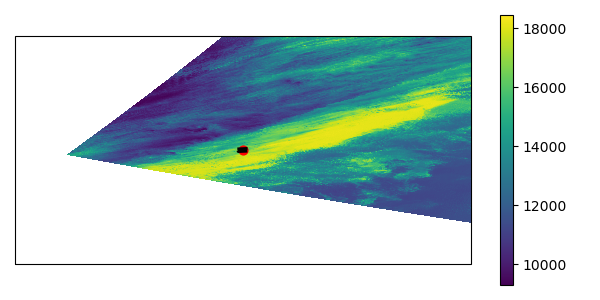

In [18]:
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_ylim([ilat-1,ilat+1])
ax.set_xlim([ilon-2,ilon+2])
cb = ax.pcolormesh(ls_scene.x,ls_scene.y,ls_scene.sel(band=1).to_array().isel(variable=0),transform=cartopy.crs.epsg(3031))
plt.scatter([ilon],[ilat],c='r',s=40,transform=ccrs.PlateCarree())
plt.plot([polarx[0],polarx[0],polarx[1],polarx[1],polarx[0]],[polary[0],polary[1],polary[1],polary[0],polary[0]],lw=2,ls='--',color='k',transform=cartopy.crs.epsg(3031))
ax.coastlines()
plt.colorbar(cb)
plt.tight_layout()

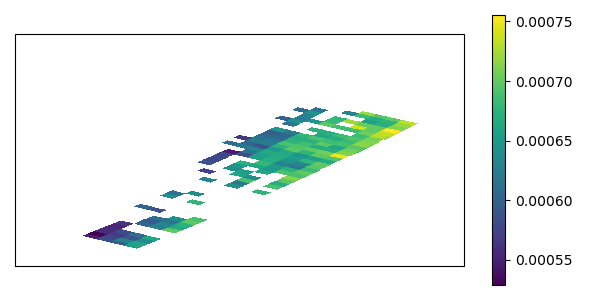

In [222]:
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# cb = ax.pcolormesh(WV_xr.x,WV_xr.y,WV_xr,transform=cartopy.crs.epsg(3031))
# ax.coastlines()
# ax.set_ylim([-72.6, -69.5])
# ax.set_xlim([-129,-123])
# plt.colorbar(cb)
# plt.tight_layout()

In [159]:
# Plot tiles of all scenes found
plot_search(gf,satellite,colnm)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]   (landsat:wrs_path,landsat:wrs_row)

**Note the bands you would like to include are assigned by passing the bandNames parameter to landsat_to_xarray using the following codes:**

'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'pan', 'cirrus', 'lwir11', 'lwir12', 'qa_pixel'

# Landsat-iQUAM validation assessment

In [41]:
# Read in processed matchups

# 20250107 is threshold=-1.9, 20250114 is thresh=-1.94, 20250205 is thresh=-1.9
out_df = lsatpath / 'Landsat_validation_20250205_202209_202303_1.0'
df1 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20250205_202109_202203_1.0'
df2 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20250205_202009_202103_1.0'
df3 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20250205_201909_202003_1.0'
df4 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20250205_201809_201903_1.0'
df5 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20250205_201709_201803_1.0'
df6 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20250205_201609_201703_1.0'
df7 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20250205_201509_201603_1.0'
df8 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20250205_201409_201503_1.0'
df9 = pd.read_pickle(out_df)
out_df = lsatpath / 'Landsat_validation_20250205_201309_201403_1.0'
df10 = pd.read_pickle(out_df)

valids = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]) 

valids = valids.set_index('DateTime')
valids = valids.sort_index()
valids['Argo_id'] = valids['Argo_id'].astype(int)

# Remove the non-numeric column for calculating daily means
numeric_valids = valids.select_dtypes(include=[np.number])
validmn = numeric_valids.groupby(numeric_valids['Argo_id']).mean()
valids = valids.reset_index()

# Group by the date component of the datetime and calculate the difference
valids['temp_dif'] = valids.groupby(valids['Argo_id'])[f'L8_SST'].diff()
validmn['temp_dif'] = valids.groupby(valids['Argo_id'])['temp_dif'].first()
valids = valids.set_index('DateTime')

validmn['std'] = valids.groupby([valids['Argo_id']])[f'L8_SST'].std()
validmn['xaxis'] = pd.to_datetime(validmn.index).dayofyear
validmn['xaxis'][validmn['xaxis']<(365/2)] = validmn['xaxis'] + 365

valids['xaxis'] = pd.to_datetime(valids.index).dayofyear
valids['xaxis'][valids['xaxis']<(365/2)] = valids['xaxis'] + 365

validmn = validmn.dropna(subset=['L8_SST'])

valids

,L8_filename,L8_SST,L8_std,center,N,S,E,W,NE,SE,NW,SW,L8_SST_max,L8_SST_min,Argo_id,Argo_SST,A_lat,A_lon,temp_dif,xaxis
DateTime,,,,,,,,,,,,,,,,,,,,
2015-12-11 10:00:00,LC08_L1GT_027110_20151211_20201016_02_T2,-1.10,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.772562,-1.274439,1614080,-1.76,-70.383110,-135.929657,NaN,345
2016-02-13 08:00:00,LC08_L1GT_027111_20160213_20201016_02_T2,-1.77,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.618873,-1.892590,1460597,-0.53,-71.686996,-135.951996,NaN,409
2016-09-23 03:00:00,LC08_L1GT_029109_20160922_20200906_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1732027,-1.83,-70.180000,-134.613007,NaN,267
2018-01-01 12:00:00,LC08_L1GT_228108_20180101_20201016_02_T2,-0.65,0.06,-0.625410,-0.572402,-0.661747,-0.614259,-0.614259,-0.541724,-0.670123,-0.605882,-0.628239,-0.430215,-0.826675,1790883,-0.05,-68.344002,-80.625000,NaN,366
2018-01-21 23:00:00,LC08_L1GT_023110_20180121_20201016_02_T2,-0.93,0.05,-0.951215,-0.928830,-0.954013,-0.979197,-0.926032,-0.956812,-0.962408,-0.903619,-0.948417,-0.793679,-1.133398,1799801,-1.08,-70.258003,-128.796005,NaN,386
2018-10-29 17:00:00,LC08_L1GT_022110_20181029_20201016_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1898109,-1.82,-70.391899,-126.625000,NaN,302
2018-12-10 02:00:00,LC08_L1GT_005109_20181209_20201016_02_T2,-1.88,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.869443,-1.889458,1969557,-1.79,-70.017700,-99.761002,NaN,344
2018-12-10 02:00:00,LC08_L1GT_005110_20181209_20201016_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1969557,-1.79,-70.017700,-99.761002,NaN,344
2019-02-23 15:00:00,LC08_L1GT_226108_20190223_20201016_02_T2,1.10,0.10,1.077545,1.088365,1.085646,1.085646,1.064006,1.091084,1.099213,1.061287,1.074826,1.358629,0.670450,1711312,1.29,-67.725304,-76.595497,NaN,419


## Visualize all validation matchups for manual QC

In [29]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/33263/status,
Dashboard: /user/tsnow03/proxy/33263/status,Workers: 4
Total threads: 4,Total memory: 29.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42459,Workers: 4
Dashboard: /user/tsnow03/proxy/33263/status,Total threads: 4
Started: Just now,Total memory: 29.67 GiB
Comm: tcp://127.0.0.1:33921,Total threads: 1
Dashboard: /user/tsnow03/proxy/43073/status,Memory: 7.42 GiB
Nanny: tcp://127.0.0.1:45663,


In [47]:
os.chdir(SSTpath)
lsatfiles = os.listdir(SSTpath)
lsatfiles = [i for i in lsatfiles if i[0]=='L']

# Remove all files from the list with repeats and Landsat mean = nan
remove = [
'LC08_L1GT_029109_20160922_20200906_02_T2', 
'LC08_L1GT_022110_20181029_20201016_02_T2', 
'LC08_L1GT_005110_20181209_20201016_02_T2',
'LC08_L1GT_228108_20200123_20201016_02_T2',
'LC08_L1GT_001108_20200929_20201006_02_T2',
'LC08_L1GT_002109_20201022_20201105_02_T2',
'LC08_L1GT_233108_20201109_20210317_02_T2',
'LC08_L1GT_233109_20201109_20210317_02_T2',
'LC08_L1GT_001109_20201202_20210312_02_T2',
'LC08_L1GT_027112_20220128_20220204_02_T2',
'LC08_L1GT_002109_20210331_20210408_02_T2'
]

lsatfiles = [i for i in lsatfiles if i[:-15] not in remove]
if len(lsatfiles)!=12:
    print('Wrong number of Landsat scenes!!!')

LC08_L1GT_026112_20220310_20220321_02_T2_172555_Cel.tif
LC08_L1GT_008109_20220107_20220114_02_T2_153344_Cel.tif
LC08_L1GT_002108_20210331_20210408_02_T2_145547_Cel.tif
LC08_L1GT_009109_20200329_20200822_02_T2_153924_Cel.tif
LC08_L1GT_029110_20200309_20201016_02_T2_174335_Cel.tif
LC08_L1GT_006109_20200221_20201016_02_T2_152108_Cel.tif
LC08_L1GT_226108_20190223_20201016_02_T2_140006_Cel.tif
LC08_L1GT_005109_20181209_20201016_02_T2_151450_Cel.tif
LC08_L1GT_228108_20180101_20201016_02_T2_141254_Cel.tif
LC08_L1GT_023110_20180121_20201016_02_T2_170636_Cel.tif
LC08_L1GT_027111_20160213_20201016_02_T2_173140_Cel.tif
LC08_L1GT_027110_20151211_20201016_02_T2_173126_Cel.tif


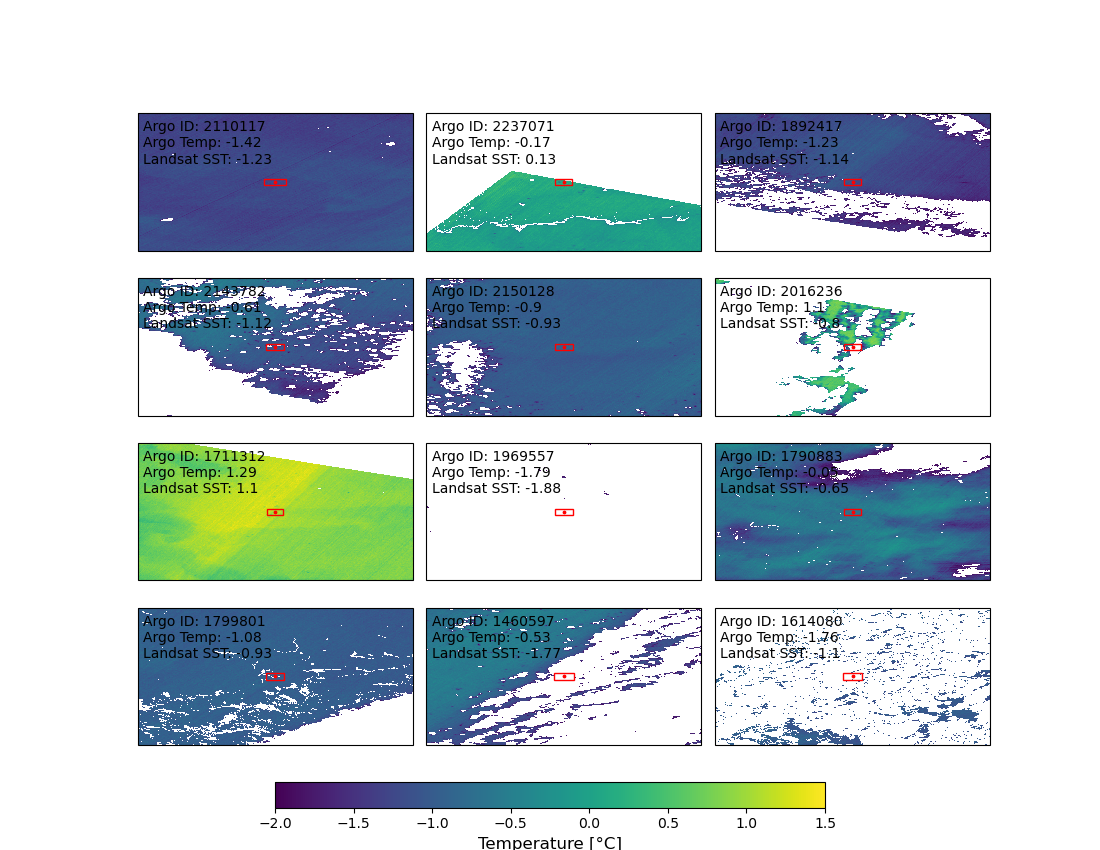

In [48]:
# Number of columns/rows for subplots
n_cols = 3
n_rows = 4

# Create one figure and a 4x7 grid of subplots
# The figsize is 10 across; adjust height as needed for clarity
fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(11, 8.5),   
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Optional: if you want them *really* close, you can fine-tune spacing:
plt.subplots_adjust(wspace=0.05, hspace=0.03)
# plt.subplots_adjust(bottom=0.15)

# Counter for subplot index, and a handle to store the last "imshow" (for colorbar)
i = 0
im_obj = None

for lsatfile in lsatfiles:
    lsID = lsatfile
    print(lsID)
    
    mrow = valids[valids['L8_filename'].str.contains(lsatfile[:-15])]
    
    for idx, row in mrow.iterrows():
        # Check if L8_SST is NaN
        if pd.isnull(row['L8_SST']):
            # If it is NaN, skip this iteration and do not plot
            continue
        
        # --- Prepare data and coordinates ---
        ilat = row['A_lat']
        ilon = row['A_lon']
        
        lat_add = km_to_decimal_degrees(dist, ilat, direction='latitude')
        lon_add = km_to_decimal_degrees(dist, ilat, direction='longitude')
        xmin, ymin, xmax, ymax = (ilon - lon_add, ilat - lat_add, 
                                  ilon + lon_add, ilat + lat_add)
        
        # Load the Landsat file
        ds = xr.open_dataset(lsatfile, chunks=dict(x=512, y=512), engine='rasterio')
        ls_scene = ds['band_data'].sel(band=1).rio.write_crs("epsg:3031", inplace=True)
        
        # Assign time coordinate
        times = pd.to_datetime(lsatfile[17:25] + lsatfile[41:47], format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times, ID=lsatfile[:-8])
        
        # Reproject to EPSG:4326
        ls_scene = ls_scene.rio.reproject("EPSG:4326")

        # Calibrate using MODIS
        ls_scene = ls_scene * calib_m + calib_b

        # Remove all pixels that are too cold
        ls_scene = ls_scene.where(ls_scene>=lthresh,np.nan)
        
        # Select the subplot axis
        ax = axes[i // n_cols, i % n_cols]
        
        # Plot on that axis, without a colorbar
        # Store the "imshow" result in im_obj so we can build one colorbar later
        im_obj = ls_scene.plot.imshow(
            x='x', y='y',
            vmin=-2.0, vmax=1.5,
            ax=ax,
            transform=ccrs.PlateCarree(),
            origin='upper',
            add_colorbar=False  # <- No individual colorbar
        )
        
        # Remove titles completely (xarray may add one by default)
        ax.set_title('')
        
        # Set extent
        ax.set_extent([ilon - 0.4, ilon + 0.4, ilat - 0.2, ilat + 0.2], crs=ccrs.PlateCarree())
        
        # Argo observation
        ax.scatter([ilon], [ilat], c='r', s=3, transform=ccrs.PlateCarree(), label='Argo location')
        
        # Draw bounding box
        polygon_show = Pgon([(xmin, ymin), (xmin, ymax), 
                             (xmax, ymax), (xmax, ymin)],
                            closed=True, edgecolor='red', facecolor='none')
        ax.add_patch(polygon_show)
        
        # Text label
        text_str = (
            f"Argo ID: {row['Argo_id']}\n"
            f"Argo Temp: {np.around(row['Argo_SST'], 2)}\n"
            f"Landsat SST: {np.around(row['L8_SST'], 2)}"
        )
        ax.text(
            0.02, 0.95,
            text_str,
            transform=ax.transAxes,
            fontsize=10,
            va='top',
            ha='left'
        )

        gc.collect()
        
        # Move to next subplot index
        i += 1
        

# --- Add a single colorbar for the entire figure ---
# We use the last "imshow" (im_obj) and attach to all subplot axes
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])

cbar = fig.colorbar(
    im_obj, 
    ax=axes.ravel().tolist(),  # or just ax=axes if axes is 2D
    cax=cbar_ax,
    orientation='horizontal',  # 'vertical' or 'horizontal'
    fraction=0.025,            # how long the colorbar is relative to axes
    pad=0.05                   # space between colorbar and subplots
)
cbar.set_label("Temperature [°C]", fontsize=12)

# plt.tight_layout()
plt.show() 

## Plot high and low quality validation data

In [44]:
# Remove low quality validation data from the valids data
rm_ids = [1460597, 1614080, 2143782, 2016236, 1790883]
rm = validmn[validmn.index.isin(rm_ids)]
validmn = validmn.drop(index=rm_ids, errors='ignore')
valids = valids[~valids['Argo_id'].isin(rm_ids)]

In [45]:
# Orthoganal Regression 
data = validmn

# Original data
x_original = np.array(data['Argo_SST'])
y_original = np.array(data['L8_SST'])

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model
linear = Model(linear_model)

# Create a RealData object using your DataFrame
data = RealData(x_original, y_original)

# Set up ODR with the model and data
odr = ODR(data, linear, beta0=[1., 0.])

# Run the regression
out = odr.run()

# Use the output
beta = out.beta
beta_err = out.sd_beta

# Print the summary
out.pprint()

# Predicting values using the ODR model
y_pred = linear_model(beta, x_original)

# Get R2
# Calculate Total Sum of Squares (SST)
y_mean = np.mean(y_original)
SST = np.sum((y_original - y_mean)**2)

# Calculate Residual Sum of Squares (SSR)
SSR = np.sum((y_original - y_pred)**2)

# Compute RMSE
rmse = np.sqrt(((y_original - y_pred) ** 2).mean())

# Calculate R^2
R2 = 1 - (SSR / SST)
print("R^2:", np.around(R2,2))
print(f"RMSE: {np.around(rmse,2)}")

Beta: [0.9604976  0.03009098]
Beta Std Error: [0.07105586 0.08645468]
Beta Covariance: [[0.30276779 0.22923813]
 [0.22923813 0.44821559]]
Residual Variance: 0.01667593078822475
Inverse Condition #: 0.06470993032016736
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.97
RMSE: 0.15


At 95% confidence interval: 0.96+/-0.14, 0.03+/-0.17, n=7


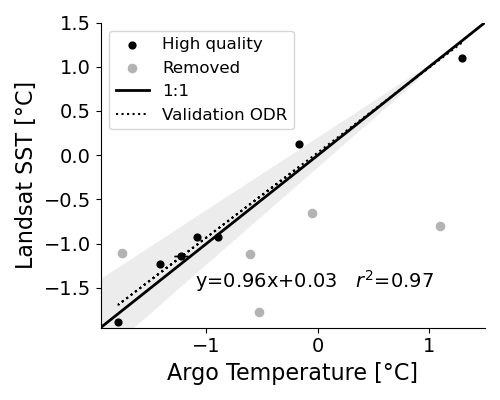

In [46]:
beta_mdn = [beta[0]-beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_mup = [beta[0]+beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_bdn = [beta[0]-beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
beta_bup = [beta[0]+beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
print(f'At 95% confidence interval: {np.around(beta[0],2)}+/-{np.around(beta_err[0]*1.96,2)}, {np.around(beta[1],2)}+/-{np.around(beta_err[1]*1.96,2)}, n={y_pred.shape[0]}')
xfill = np.array([-4.3,0.9])


# Plot data points and 1:1 line
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(labelsize=14)

xi = np.arange(-7.0,5.0,1.0)

# lower_err = abs(data['L8_SST'] - data['L8_SST_min'])  # distance to lower bound
# upper_err = abs(data['L8_SST_max'] - data['L8_SST'])  # distance to upper bound

ax.scatter(x_original,y_original,color='k',linewidth=0,s=35,label='High quality')
ax.errorbar(x_original,y_original,yerr=validmn['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# ax.errorbar(data['Argo_SST'],data['L8_SST'],yerr=[lower_err,upper_err],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# ax.scatter(data['Argo_SST'],data['center'],color='r',linewidth=0,s=25,label='_no label_')
ax.scatter(rm['Argo_SST'],rm['L8_SST'],color='0.7', s=35, label='Removed',zorder=2)
ax.plot(xi,xi,color='k',linewidth=2, label='1:1')
ax.plot(x_original, y_pred, color='k', ls=':', label='Validation ODR')
ax.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.1, facecolor='0.3')
# a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='r',linewidth=2,label='RANSAC regression')
# a1.scatter(xC,yLC,color='r',linewidth=0,s=35,label='_no label_')
# a1.plot(xi,xi*resultC.params.L8_SST+resultC.params.Intercept,color='k',linewidth=2,label='OLS regression')
# a1.text(-2.1,-2.85,f'y={np.around(resultC.params.L8_SST,2)}x+{np.around(resultC.params.Intercept,2)}   p={p_val}',fontsize=12)
ax.text(-1.1,-1.5,f'y={np.around(beta[0],2)}x+{np.around(beta[1],2)}   $r^2$={np.around(R2,2)}',fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-1.95,1.5])
ax.set_xlim([-1.95,1.5])
ax.set_xlabel('Argo Temperature [°C]',fontsize=16)
ax.set_ylabel('Landsat SST [°C]',fontsize=16)
ax.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()